In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_pr_cls = discriminator(y_pr.detach())
        x_cls = discriminator(x)
        
        _dis = nn.CrossEntropyLoss()(y_cls.float(), torch.ones(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(x_cls.float(), torch.zeros(x_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), 2 * torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device) )

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        _gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        # Perceptual loss
        perceptual_loss = PerceptualLoss()(y_pr, y)
        
        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae + _ssim
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        perceptual_l += perceptual_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), perceptual_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        x_cls = discriminator(x)
        x_cls = Activation(name=DIS_ACT)(x_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        total = x.size()[0]
        _, predicted = torch.max(y_cls.data, 1)
        correct = (predicted == torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(y_pr_cls.data, 1)
        correct = (predicted == 2 * torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(x_cls.data, 1)
        correct = (predicted == torch.zeros(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7ff3e547fdf0>,)

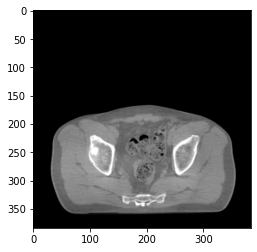

In [22]:
plt.imshow(x.squeeze(), 'gray'),

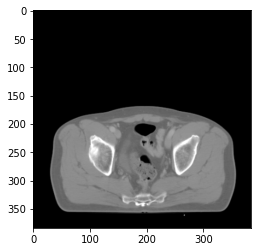

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_perceptual, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss perceptual": loss_perceptual,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [05:48,  2.07s/it]
168it [00:47,  3.53it/s]
24it [00:07,  3.35it/s]
168it [05:47,  2.07s/it]
168it [00:47,  3.51it/s]
24it [00:07,  3.34it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.51it/s]
24it [00:07,  3.35it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.51it/s]
24it [00:07,  3.35it/s]
168it [05:47,  2.07s/it]
168it [00:47,  3.52it/s]
24it [00:07,  3.35it/s]
168it [05:48,  2.08s/it]
168it [00:47,  3.52it/s]
24it [00:07,  3.34it/s]
168it [05:47,  2.07s/it]
168it [00:47,  3.51it/s]
24it [00:07,  3.34it/s]
168it [05:47,  2.07s/it]
168it [00:47,  3.51it/s]
24it [00:07,  3.35it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.52it/s]
24it [00:07,  3.35it/s]
168it [05:47,  2.07s/it]
168it [00:47,  3.52it/s]
24it [00:07,  3.35it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.52it/s]
24it [00:07,  3.35it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.52it/s]
24it [00:07,  3.35it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.52it/s]
24it [00:07,  3.35it/s]
168it [05:47,  2.07s/it]
168it [00:47,

KeyboardInterrupt: 

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9022899866104126
psnr score = 26.716175079345703
snr score = 16.77911376953125
mae error = 0.017150679603219032
air dice score = 0.9946773854034114
bone dice score = 0.9424665337518874


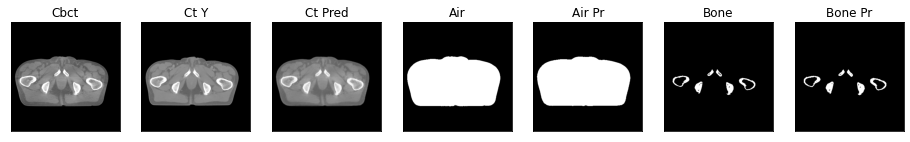

ssim score = 0.9039484858512878
psnr score = 26.66724967956543
snr score = 16.777721405029297
mae error = 0.01717584766447544
air dice score = 0.9949828254403847
bone dice score = 0.9360079107227574


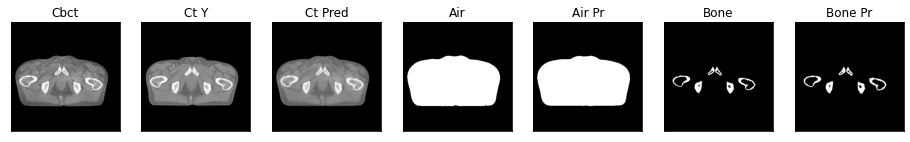

ssim score = 0.9022403359413147
psnr score = 26.468393325805664
snr score = 16.741764068603516
mae error = 0.018337717279791832
air dice score = 0.9953407280488218
bone dice score = 0.9379375815837434


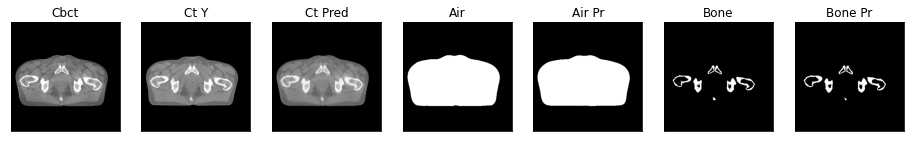

ssim score = 0.899607241153717
psnr score = 26.567054748535156
snr score = 16.929676055908203
mae error = 0.01823471300303936
air dice score = 0.9954933705372871
bone dice score = 0.9325758387830145


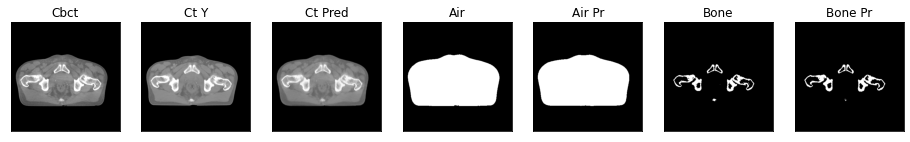

ssim score = 0.8982483148574829
psnr score = 26.696834564208984
snr score = 17.099760055541992
mae error = 0.01788078248500824
air dice score = 0.9958030978572693
bone dice score = 0.9298481645211432


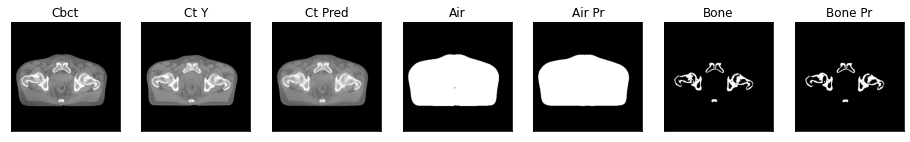

ssim score = 0.8934450149536133
psnr score = 26.622329711914062
snr score = 17.161788940429688
mae error = 0.018517356365919113
air dice score = 0.9958153920795725
bone dice score = 0.9249979462751582


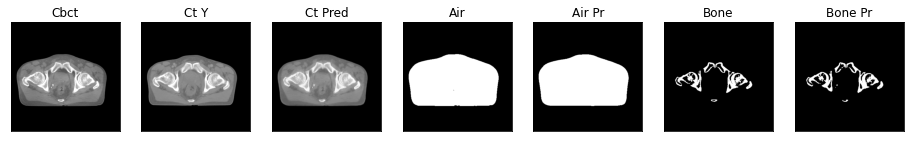

ssim score = 0.8910196423530579
psnr score = 26.52880096435547
snr score = 17.044204711914062
mae error = 0.018716564401984215
air dice score = 0.9948740897441165
bone dice score = 0.9311220441205276


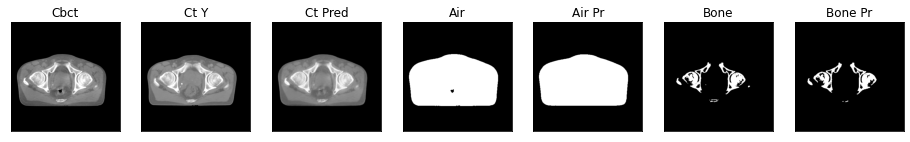

ssim score = 0.8916653394699097
psnr score = 26.8216609954834
snr score = 17.151527404785156
mae error = 0.018010040745139122
air dice score = 0.9950987915809772
bone dice score = 0.9428670963251797


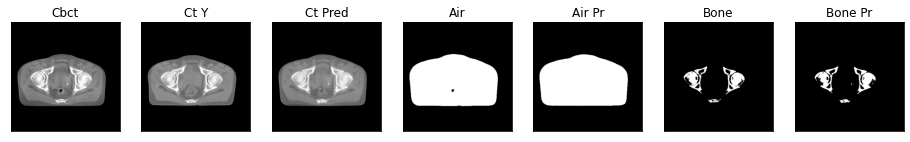

1it [00:02,  2.64s/it]

ssim score = 0.8930884599685669
psnr score = 26.993175506591797
snr score = 17.228485107421875
mae error = 0.01766218990087509
air dice score = 0.995655038919324
bone dice score = 0.9466793168885514


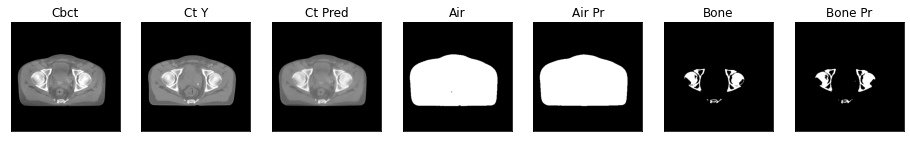

ssim score = 0.8969313502311707
psnr score = 27.166460037231445
snr score = 17.386486053466797
mae error = 0.01743237115442753
air dice score = 0.9951866221290948
bone dice score = 0.943545203316783


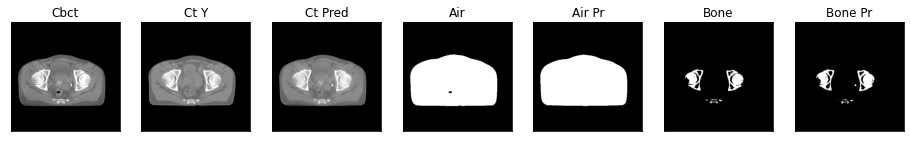

ssim score = 0.9018659591674805
psnr score = 27.32494354248047
snr score = 17.577239990234375
mae error = 0.017392538487911224
air dice score = 0.9952907517046276
bone dice score = 0.9529892157894149


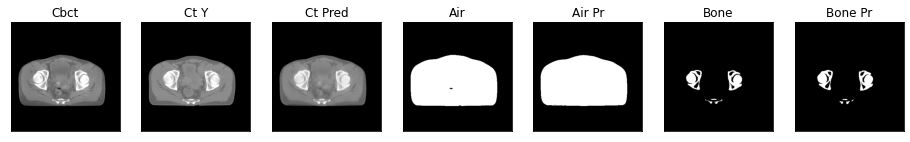

ssim score = 0.9009273648262024
psnr score = 27.079242706298828
snr score = 17.35525131225586
mae error = 0.017894277349114418
air dice score = 0.9923228408648206
bone dice score = 0.9630879561277885


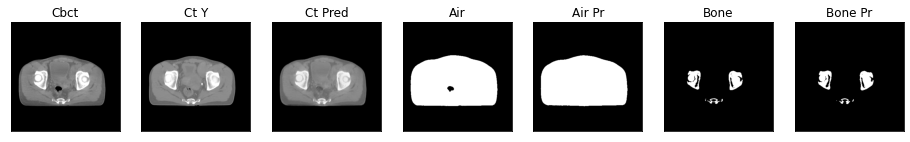

ssim score = 0.905700147151947
psnr score = 27.0062255859375
snr score = 17.250308990478516
mae error = 0.018229858949780464
air dice score = 0.9901997218122656
bone dice score = 0.9686371841158773


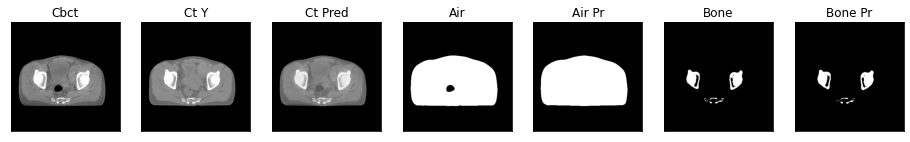

ssim score = 0.9048455357551575
psnr score = 27.044971466064453
snr score = 17.147098541259766
mae error = 0.017707878723740578
air dice score = 0.989259964485153
bone dice score = 0.9526837021646573


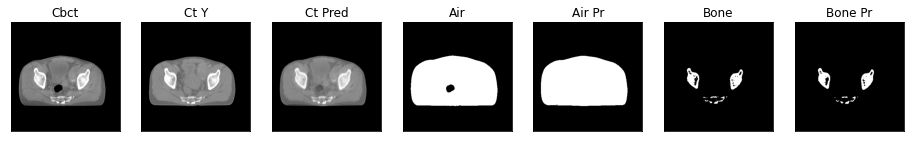

ssim score = 0.9016550183296204
psnr score = 26.77961540222168
snr score = 16.79608154296875
mae error = 0.017835654318332672
air dice score = 0.989223441170777
bone dice score = 0.9326748115423359


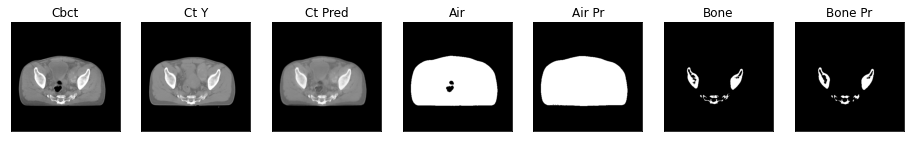

ssim score = 0.893832266330719
psnr score = 26.067426681518555
snr score = 16.107376098632812
mae error = 0.018966713920235634
air dice score = 0.9899577052380545
bone dice score = 0.9444791016850346


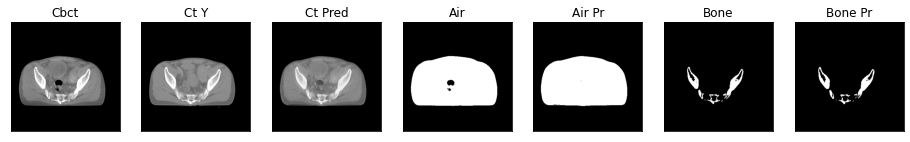

2it [00:04,  2.54s/it]

ssim score = 0.889977216720581
psnr score = 25.41597557067871
snr score = 15.453381538391113
mae error = 0.020108381286263466
air dice score = 0.9885097760008889
bone dice score = 0.9464411557441103


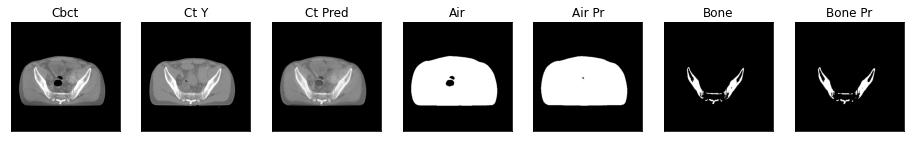

ssim score = 0.8830786347389221
psnr score = 24.94243812561035
snr score = 14.87808609008789
mae error = 0.020727936178445816
air dice score = 0.9860071735376322
bone dice score = 0.9359971288439286


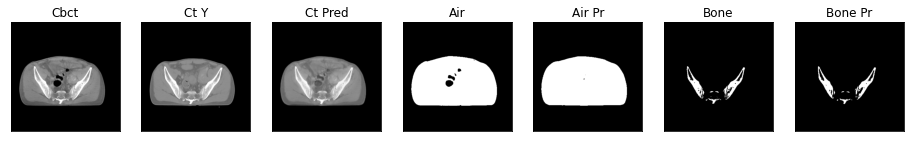

ssim score = 0.8806567788124084
psnr score = 24.496259689331055
snr score = 14.381223678588867
mae error = 0.021115293726325035
air dice score = 0.9862600536193183
bone dice score = 0.9324879652467712


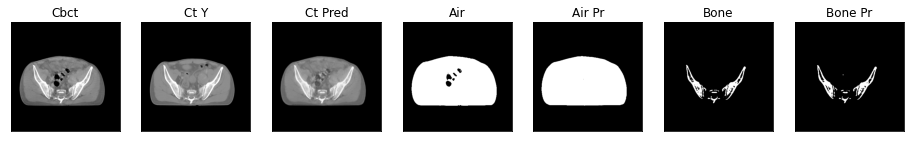

ssim score = 0.8819314241409302
psnr score = 23.99481773376465
snr score = 13.867472648620605
mae error = 0.021756267175078392
air dice score = 0.9892768332339527
bone dice score = 0.9248707777386118


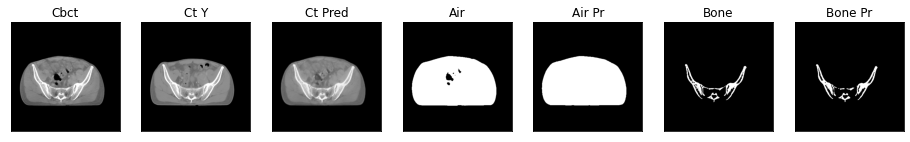

ssim score = 0.8800647258758545
psnr score = 23.759754180908203
snr score = 13.567562103271484
mae error = 0.0219290591776371
air dice score = 0.9913173754639344
bone dice score = 0.9141879441969704


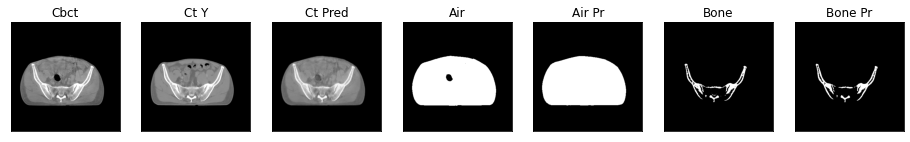

ssim score = 0.8780968189239502
psnr score = 23.443859100341797
snr score = 13.192237854003906
mae error = 0.021913442760705948
air dice score = 0.991380200860842
bone dice score = 0.9233933161963574


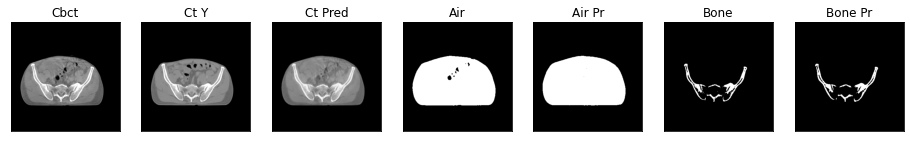

ssim score = 0.8827334046363831
psnr score = 23.56844711303711
snr score = 13.28339958190918
mae error = 0.021517131477594376
air dice score = 0.993766655080531
bone dice score = 0.9311624566032423


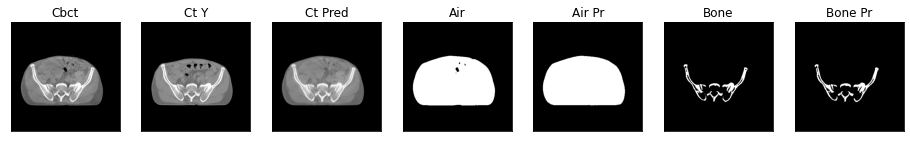

ssim score = 0.8811123371124268
psnr score = 23.358478546142578
snr score = 13.02486515045166
mae error = 0.02210896648466587
air dice score = 0.9948978397734514
bone dice score = 0.9192949907244978


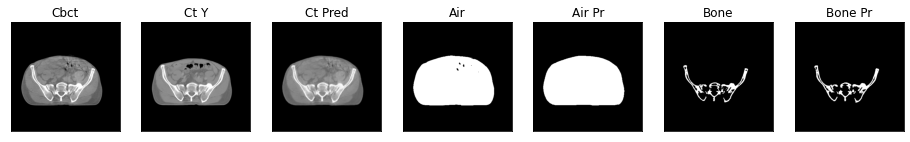

3it [00:07,  2.40s/it]

ssim score = 0.8816429972648621
psnr score = 23.381107330322266
snr score = 12.950492858886719
mae error = 0.02201255038380623
air dice score = 0.9963799508622881
bone dice score = 0.9310995229121147


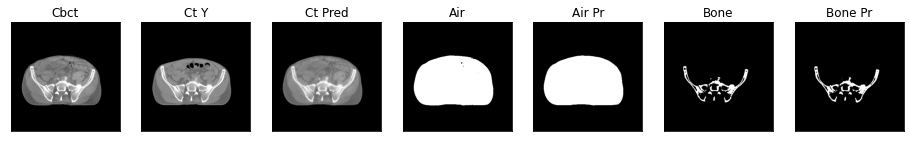

ssim score = 0.8849532604217529
psnr score = 23.650272369384766
snr score = 13.136924743652344
mae error = 0.02102542854845524
air dice score = 0.9955957796921939
bone dice score = 0.92123097433706


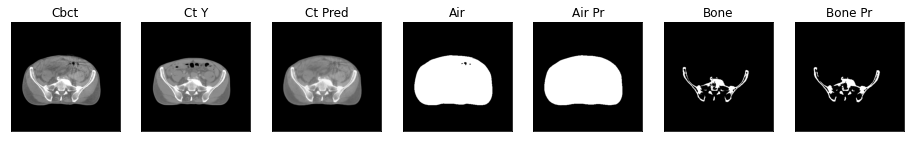

ssim score = 0.883863627910614
psnr score = 23.729331970214844
snr score = 13.124798774719238
mae error = 0.02110626921057701
air dice score = 0.9940000246405633
bone dice score = 0.9228599327338303


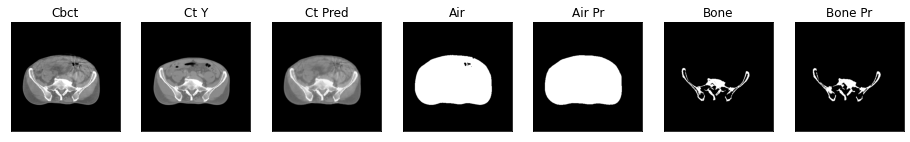

ssim score = 0.8817787170410156
psnr score = 23.675209045410156
snr score = 13.029569625854492
mae error = 0.021345483139157295
air dice score = 0.9924313504722682
bone dice score = 0.9266850209041839


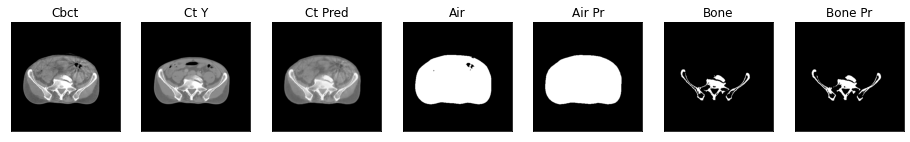

ssim score = 0.8687182068824768
psnr score = 24.161128997802734
snr score = 15.533286094665527
mae error = 0.023672718554735184
air dice score = 0.9958416064136691
bone dice score = 0.9693941286705373


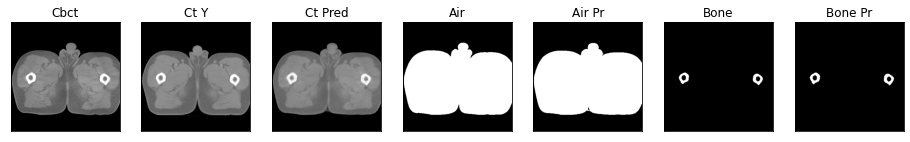

ssim score = 0.8749773502349854
psnr score = 24.81905174255371
snr score = 16.23046875
mae error = 0.02202945575118065
air dice score = 0.9966646001239946
bone dice score = 0.9666861484521716


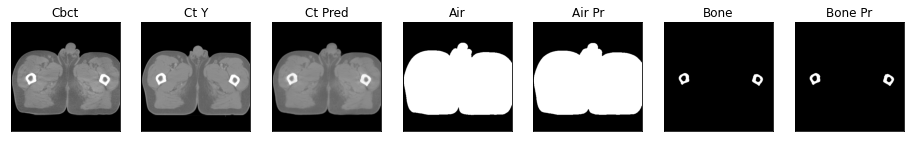

ssim score = 0.8832559585571289
psnr score = 25.48398208618164
snr score = 16.982845306396484
mae error = 0.020683301612734795
air dice score = 0.9965821124392653
bone dice score = 0.9539181286560487


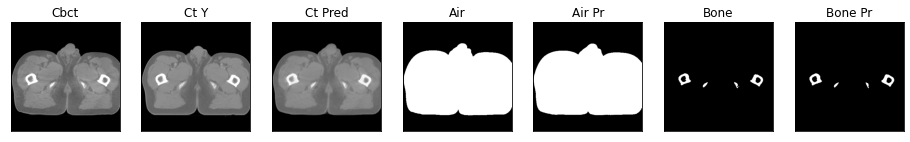

ssim score = 0.8879722356796265
psnr score = 25.851957321166992
snr score = 17.513378143310547
mae error = 0.02071932889521122
air dice score = 0.9965260120211034
bone dice score = 0.9623749801561776


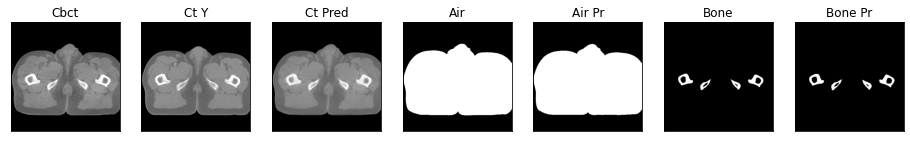

4it [00:09,  2.37s/it]

ssim score = 0.8894826769828796
psnr score = 26.153892517089844
snr score = 17.943456649780273
mae error = 0.020412662997841835
air dice score = 0.9965270360175074
bone dice score = 0.9509403107120341


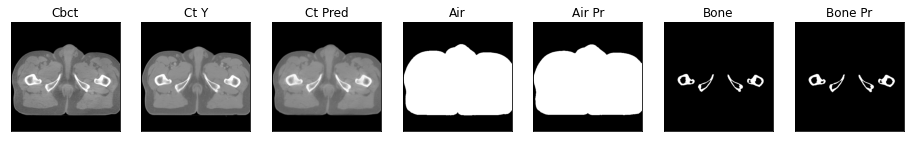

ssim score = 0.8915553092956543
psnr score = 26.652816772460938
snr score = 18.545616149902344
mae error = 0.019835233688354492
air dice score = 0.9962661607132021
bone dice score = 0.9462442150237778


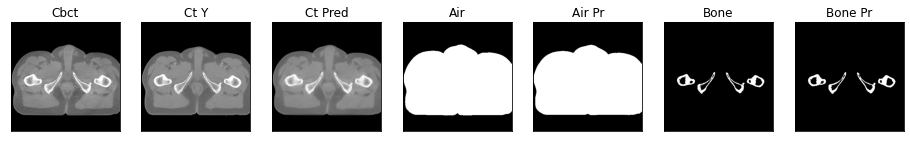

ssim score = 0.8929203152656555
psnr score = 27.032014846801758
snr score = 18.991918563842773
mae error = 0.01988372579216957
air dice score = 0.996285636380164
bone dice score = 0.9436757816761774


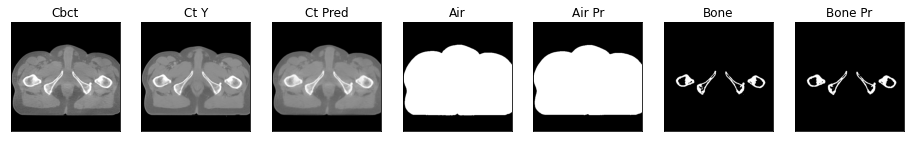

ssim score = 0.8918523788452148
psnr score = 27.189428329467773
snr score = 19.139440536499023
mae error = 0.019298285245895386
air dice score = 0.9963094727559382
bone dice score = 0.9506477483040238


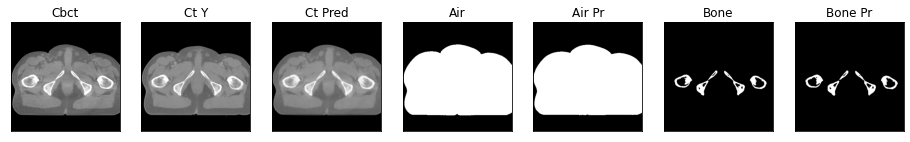

ssim score = 0.8959710001945496
psnr score = 27.354278564453125
snr score = 19.29062843322754
mae error = 0.01890820451080799
air dice score = 0.9965583542785523
bone dice score = 0.9504509068806317


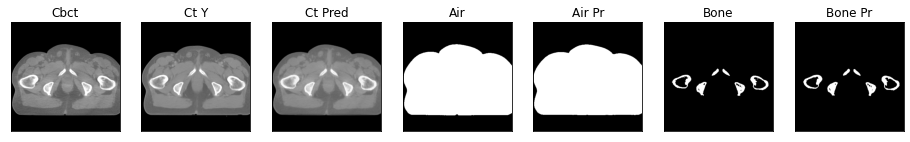

ssim score = 0.895629346370697
psnr score = 27.411224365234375
snr score = 19.359573364257812
mae error = 0.01915123499929905
air dice score = 0.9966592226522782
bone dice score = 0.9493861727336917


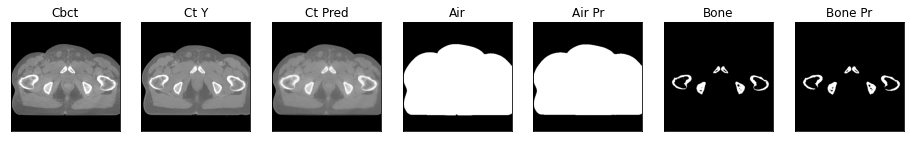

ssim score = 0.8964046239852905
psnr score = 27.413421630859375
snr score = 19.400854110717773
mae error = 0.019087299704551697
air dice score = 0.9967581482350272
bone dice score = 0.9476821192058755


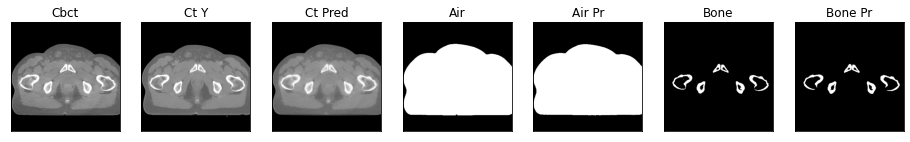

ssim score = 0.8938418626785278
psnr score = 27.340373992919922
snr score = 19.469097137451172
mae error = 0.019676905125379562
air dice score = 0.9970832857237378
bone dice score = 0.9459459459464568


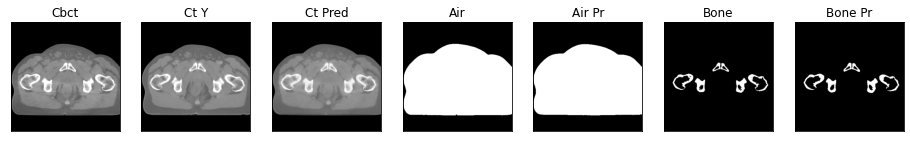

5it [00:11,  2.35s/it]

ssim score = 0.8935334086418152
psnr score = 27.361860275268555
snr score = 19.58527183532715
mae error = 0.0201552864164114
air dice score = 0.9968254350720169
bone dice score = 0.9513589723509723


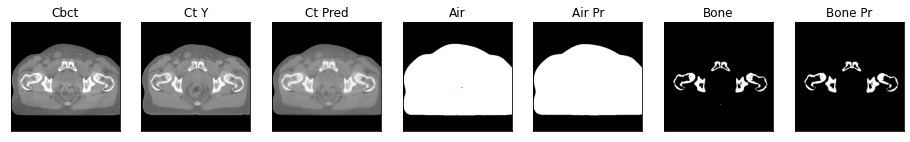

ssim score = 0.8824173212051392
psnr score = 26.749774932861328
snr score = 18.939136505126953
mae error = 0.021395856514573097
air dice score = 0.9962906577739136
bone dice score = 0.9315574717073558


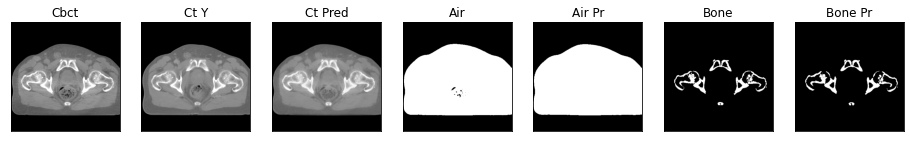

ssim score = 0.8821356296539307
psnr score = 26.702281951904297
snr score = 18.963830947875977
mae error = 0.02142072282731533
air dice score = 0.9942728040181508
bone dice score = 0.9249417249422248


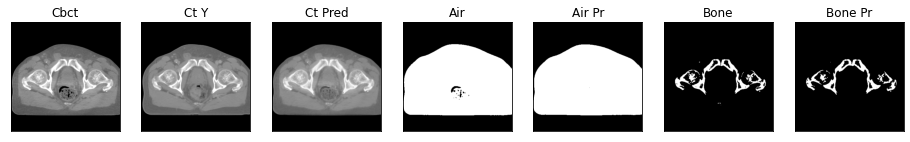

ssim score = 0.8801950216293335
psnr score = 26.54235076904297
snr score = 18.667804718017578
mae error = 0.021462608128786087
air dice score = 0.9947298836918872
bone dice score = 0.9053512288660855


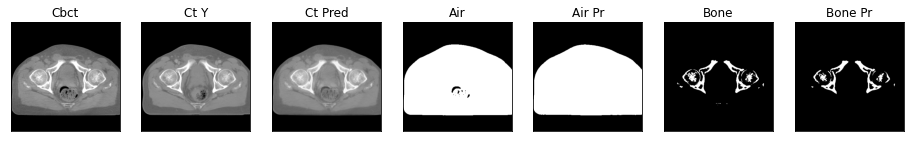

ssim score = 0.8831648826599121
psnr score = 26.329877853393555
snr score = 18.276771545410156
mae error = 0.02102844975888729
air dice score = 0.9953445747800614
bone dice score = 0.8947628947639367


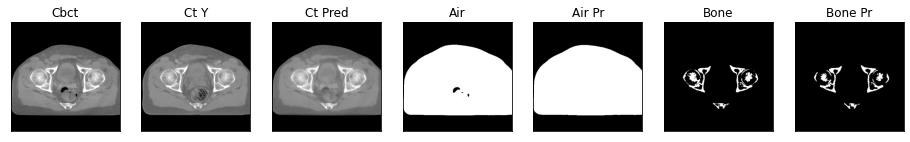

ssim score = 0.881718635559082
psnr score = 26.04421615600586
snr score = 17.90052032470703
mae error = 0.020929893478751183
air dice score = 0.996661255245507
bone dice score = 0.8807484220031475


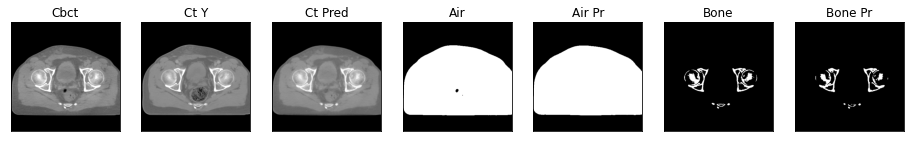

ssim score = 0.8803340792655945
psnr score = 25.829429626464844
snr score = 17.701425552368164
mae error = 0.021236563101410866
air dice score = 0.9973795903303209
bone dice score = 0.8913975122829372


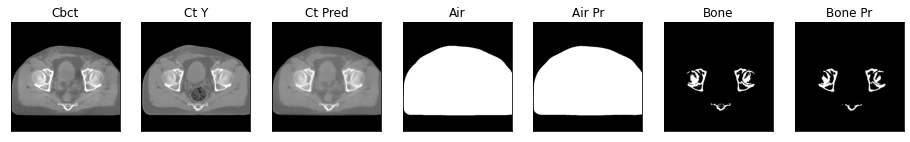

ssim score = 0.8698891401290894
psnr score = 25.67586898803711
snr score = 17.557903289794922
mae error = 0.022212086245417595
air dice score = 0.9971985677445705
bone dice score = 0.9115975780166595


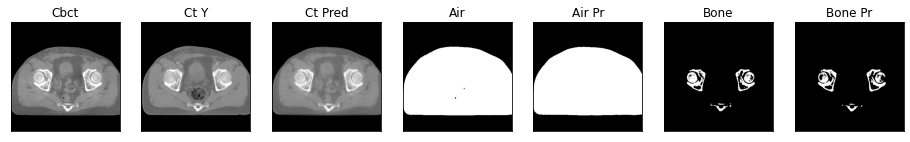

6it [00:13,  2.28s/it]

ssim score = 0.8770240545272827
psnr score = 26.05167007446289
snr score = 17.99529266357422
mae error = 0.02169254794716835
air dice score = 0.9973623618343083
bone dice score = 0.9413549941985062


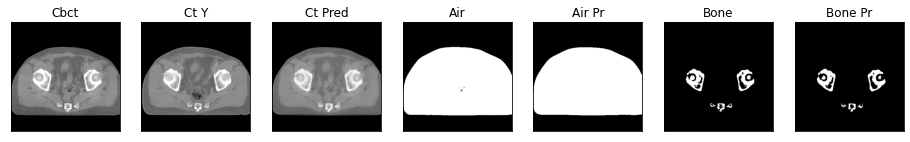

ssim score = 0.8777486681938171
psnr score = 26.44809913635254
snr score = 18.461803436279297
mae error = 0.021862128749489784
air dice score = 0.9971938950106102
bone dice score = 0.9638699663709246


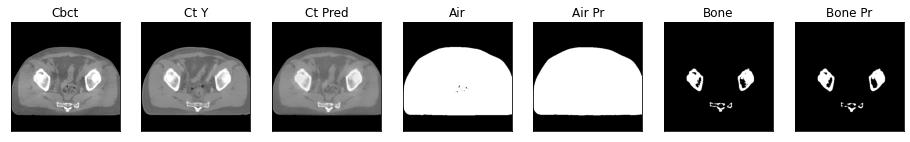

ssim score = 0.8839251399040222
psnr score = 26.200244903564453
snr score = 18.0948429107666
mae error = 0.02134495973587036
air dice score = 0.9971882503701325
bone dice score = 0.9425646026334221


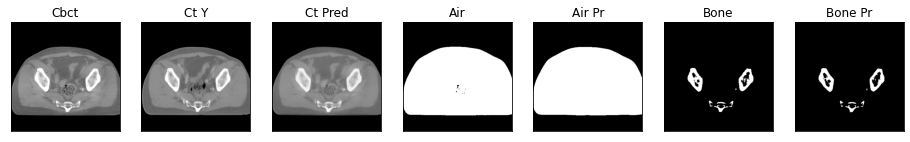

ssim score = 0.877665102481842
psnr score = 25.69255828857422
snr score = 17.66878318786621
mae error = 0.022835884243249893
air dice score = 0.9963145039496359
bone dice score = 0.9597455854049732


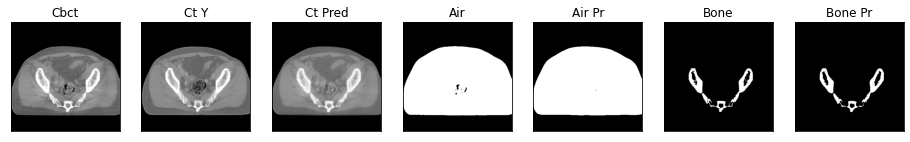

ssim score = 0.8778456449508667
psnr score = 25.89533042907715
snr score = 17.951704025268555
mae error = 0.02285468578338623
air dice score = 0.9947834285466205
bone dice score = 0.9588696138782955


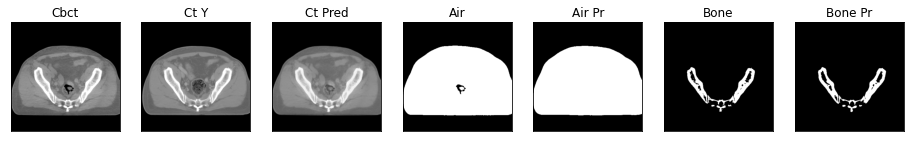

ssim score = 0.8614111542701721
psnr score = 25.648242950439453
snr score = 17.726171493530273
mae error = 0.02418900653719902
air dice score = 0.9947958515148925
bone dice score = 0.9503257899534062


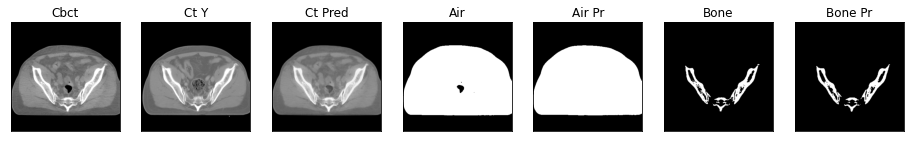

ssim score = 0.8598197102546692
psnr score = 25.753894805908203
snr score = 17.844362258911133
mae error = 0.0242195762693882
air dice score = 0.9970559130664619
bone dice score = 0.9568776907335953


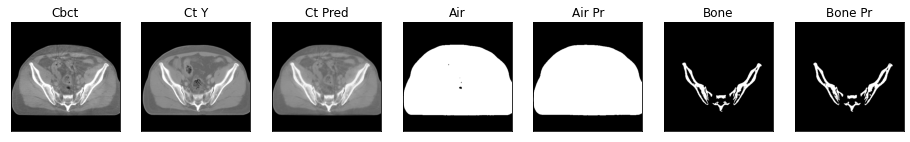

ssim score = 0.8071832060813904
psnr score = 21.169031143188477
snr score = 11.049237251281738
mae error = 0.03590657189488411
air dice score = 0.982398781382664
bone dice score = 0.9573203673701426


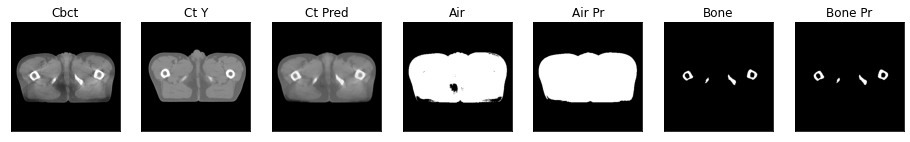

7it [00:16,  2.29s/it]

ssim score = 0.7942430973052979
psnr score = 20.795249938964844
snr score = 10.888439178466797
mae error = 0.03821416571736336
air dice score = 0.9824386276249792
bone dice score = 0.9327768014074522


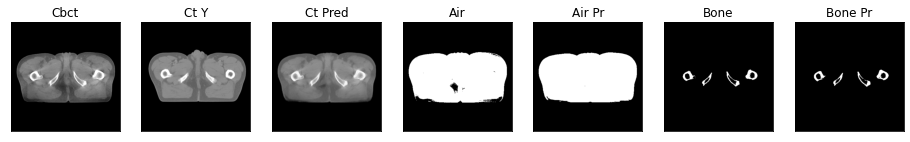

ssim score = 0.7905356287956238
psnr score = 20.794878005981445
snr score = 11.019205093383789
mae error = 0.03861984238028526
air dice score = 0.9835830367243481
bone dice score = 0.9048723897931897


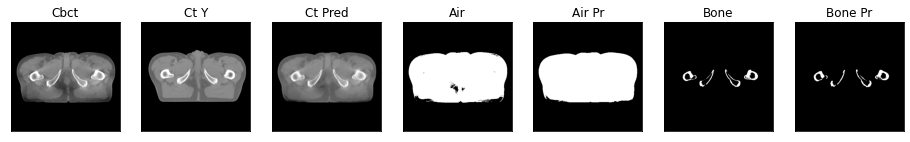

ssim score = 0.7947303056716919
psnr score = 21.099489212036133
snr score = 11.394220352172852
mae error = 0.037434037774801254
air dice score = 0.98313195358298
bone dice score = 0.9148379303419601


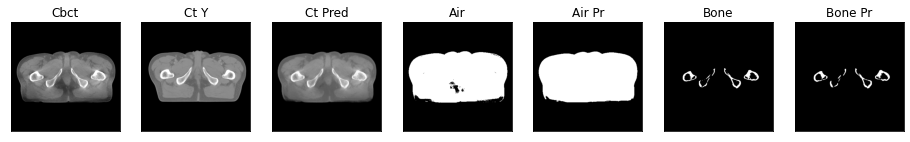

ssim score = 0.7935028672218323
psnr score = 21.097660064697266
snr score = 11.439953804016113
mae error = 0.03752407059073448
air dice score = 0.9846402290202553
bone dice score = 0.9008264462829432


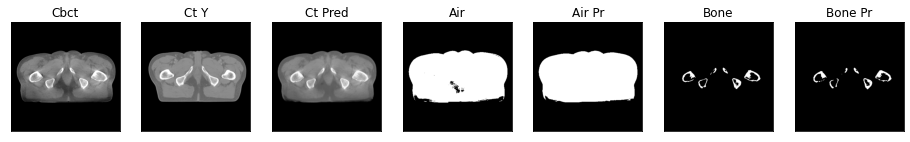

ssim score = 0.793296217918396
psnr score = 21.289377212524414
snr score = 11.637289047241211
mae error = 0.03666352853178978
air dice score = 0.9850383187313801
bone dice score = 0.9107680722908365


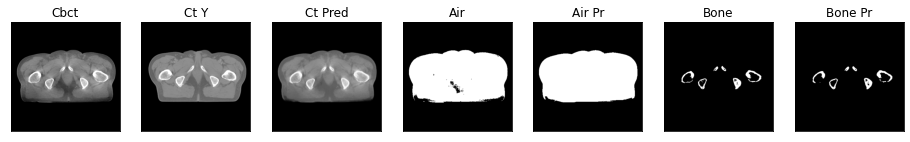

ssim score = 0.7974145412445068
psnr score = 21.43597412109375
snr score = 11.777382850646973
mae error = 0.03581956401467323
air dice score = 0.9849303849303986
bone dice score = 0.9254901960798227


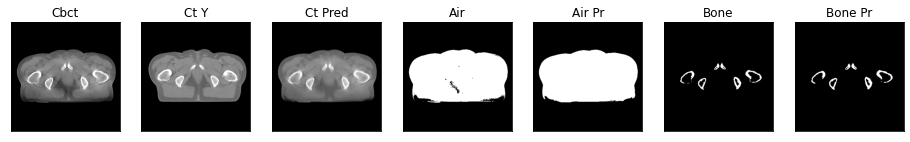

ssim score = 0.798224151134491
psnr score = 21.338153839111328
snr score = 11.693672180175781
mae error = 0.035981468856334686
air dice score = 0.9865161832931021
bone dice score = 0.9278275169024698


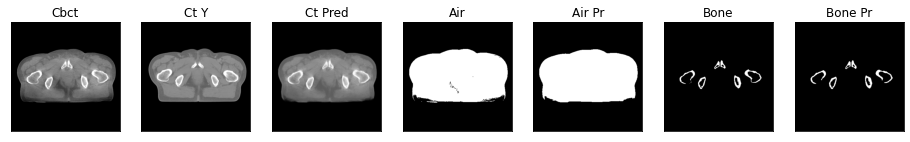

ssim score = 0.7967719435691833
psnr score = 21.235137939453125
snr score = 11.648663520812988
mae error = 0.03704012930393219
air dice score = 0.9875098072812977
bone dice score = 0.9132585751993196


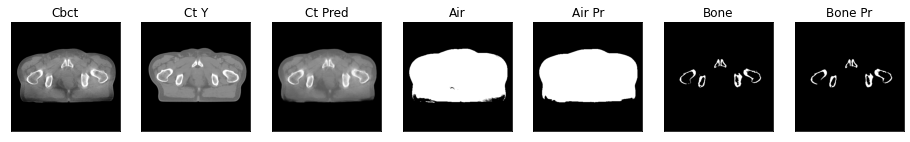

8it [00:18,  2.23s/it]

ssim score = 0.7885600924491882
psnr score = 21.07041358947754
snr score = 11.582498550415039
mae error = 0.038624394685029984
air dice score = 0.9877812694153668
bone dice score = 0.8892072588365296


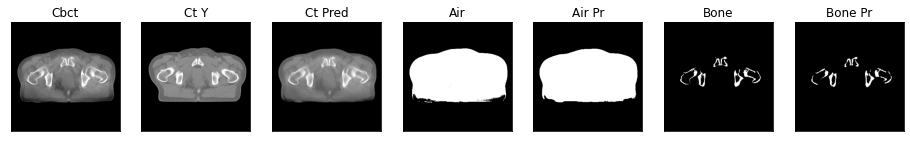

ssim score = 0.7785526514053345
psnr score = 20.95165252685547
snr score = 11.499566078186035
mae error = 0.03960522264242172
air dice score = 0.9865212156066473
bone dice score = 0.8759509392970665


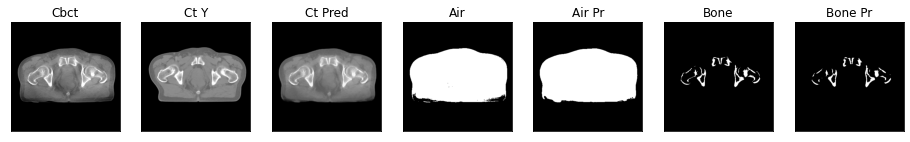

ssim score = 0.7687968015670776
psnr score = 20.886995315551758
snr score = 11.467615127563477
mae error = 0.039496079087257385
air dice score = 0.9863551955217175
bone dice score = 0.8686674008828652


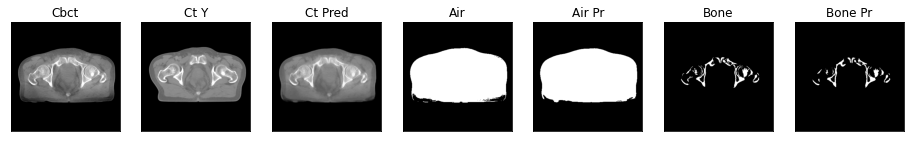

ssim score = 0.7690918445587158
psnr score = 20.833415985107422
snr score = 11.530853271484375
mae error = 0.04003957659006119
air dice score = 0.9857994735239997
bone dice score = 0.867840178822746


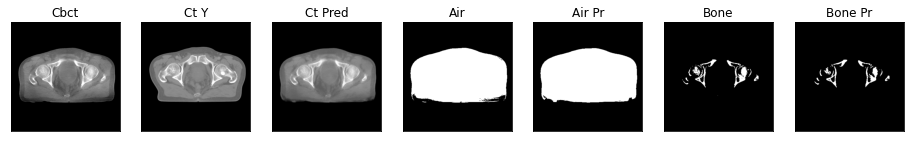

ssim score = 0.7725229263305664
psnr score = 20.70425796508789
snr score = 11.38570785522461
mae error = 0.04037032276391983
air dice score = 0.9843810137572528
bone dice score = 0.8572318231378292


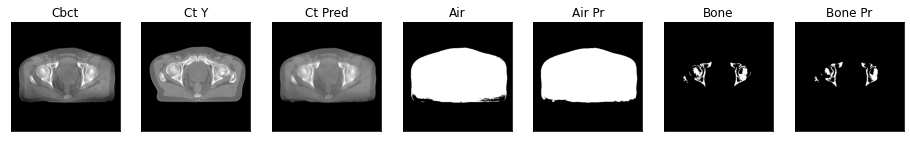

ssim score = 0.787710964679718
psnr score = 21.24008560180664
snr score = 11.722373008728027
mae error = 0.03705505654215813
air dice score = 0.9837803000465611
bone dice score = 0.8662184873972064


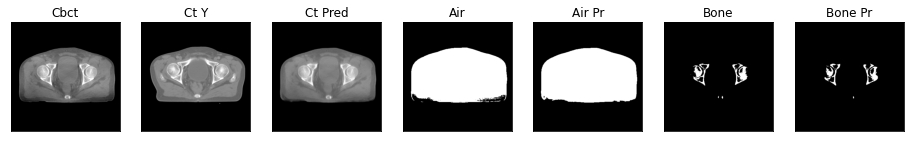

ssim score = 0.8044077157974243
psnr score = 22.007415771484375
snr score = 12.31930923461914
mae error = 0.033314257860183716
air dice score = 0.9838826463568489
bone dice score = 0.9122439826594073


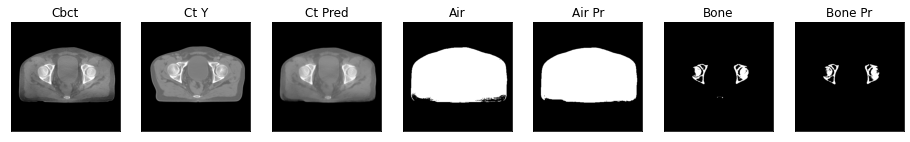

ssim score = 0.8119855523109436
psnr score = 22.381961822509766
snr score = 12.708024978637695
mae error = 0.03174339607357979
air dice score = 0.9838101971594155
bone dice score = 0.9261927416076363


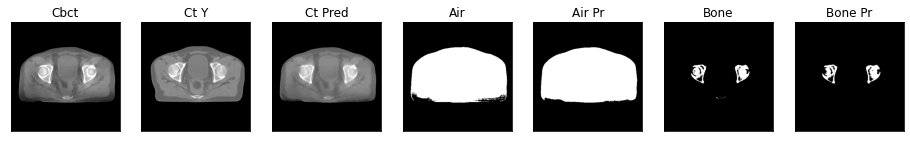

9it [00:20,  2.25s/it]

ssim score = 0.8149102330207825
psnr score = 22.4840087890625
snr score = 12.891902923583984
mae error = 0.031733762472867966
air dice score = 0.98361506126466
bone dice score = 0.9527154823027193


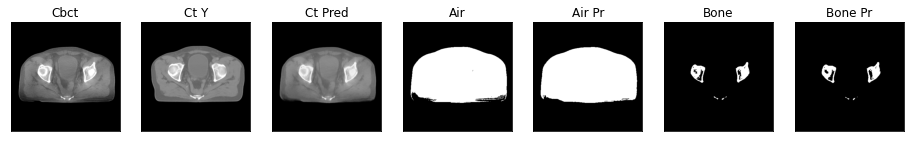

ssim score = 0.8145695924758911
psnr score = 22.28565216064453
snr score = 12.78571891784668
mae error = 0.032794591039419174
air dice score = 0.9831017112643501
bone dice score = 0.9353203257038667


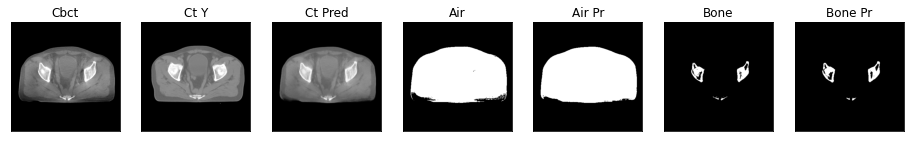

ssim score = 0.8093290328979492
psnr score = 22.651691436767578
snr score = 13.088329315185547
mae error = 0.03144742175936699
air dice score = 0.9833708183540977
bone dice score = 0.9484293633470783


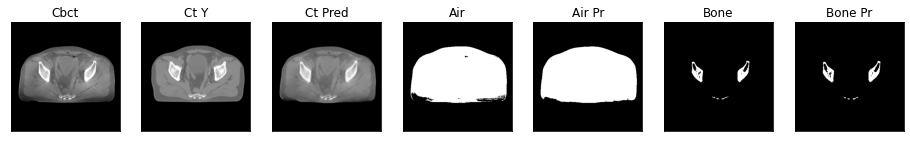

ssim score = 0.8153935670852661
psnr score = 23.06077766418457
snr score = 13.461021423339844
mae error = 0.029713882133364677
air dice score = 0.9831185236879681
bone dice score = 0.9499640028806702


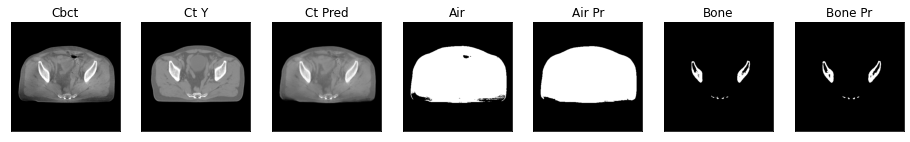

ssim score = 0.8122141361236572
psnr score = 22.927528381347656
snr score = 13.365518569946289
mae error = 0.03103322722017765
air dice score = 0.9823257452336028
bone dice score = 0.926853875905047


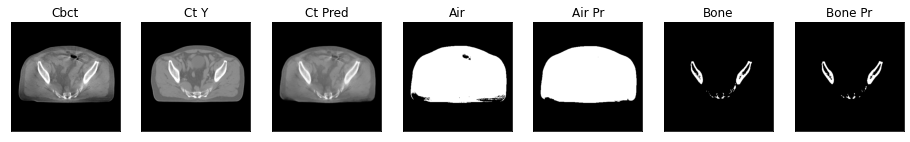

ssim score = 0.8100752830505371
psnr score = 22.894397735595703
snr score = 13.462891578674316
mae error = 0.03139017894864082
air dice score = 0.9819570170577164
bone dice score = 0.9259901705705986


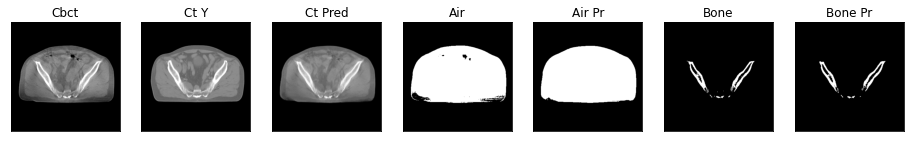

ssim score = 0.8121321201324463
psnr score = 22.841100692749023
snr score = 13.42734432220459
mae error = 0.03131289780139923
air dice score = 0.9820737331252528
bone dice score = 0.9084169884184028


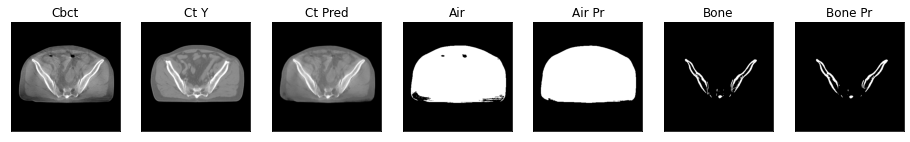

ssim score = 0.8151697516441345
psnr score = 23.15801239013672
snr score = 13.732987403869629
mae error = 0.03044305182993412
air dice score = 0.9827296374285716
bone dice score = 0.9124099815790921


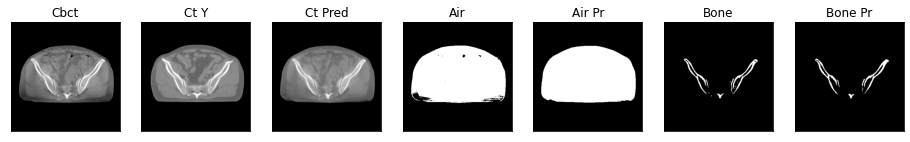

10it [00:22,  2.20s/it]

ssim score = 0.8197357654571533
psnr score = 23.2681884765625
snr score = 13.842422485351562
mae error = 0.02988641895353794
air dice score = 0.9826389505263499
bone dice score = 0.9066006600675478


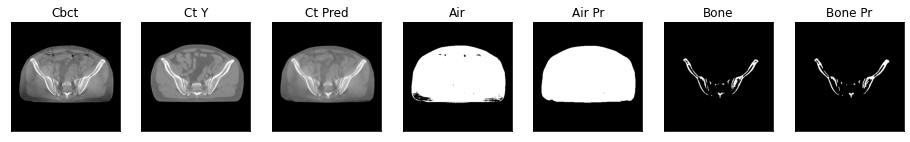

ssim score = 0.8792718648910522
psnr score = 24.49620819091797
snr score = 14.930341720581055
mae error = 0.022754665464162827
air dice score = 0.9959770068608593
bone dice score = 0.9313613955278209


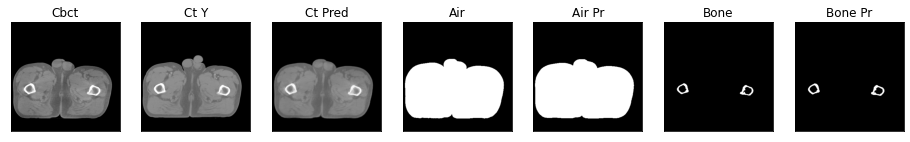

ssim score = 0.8779931664466858
psnr score = 24.750282287597656
snr score = 15.248808860778809
mae error = 0.02246243692934513
air dice score = 0.9958916420593177
bone dice score = 0.9180555555584008


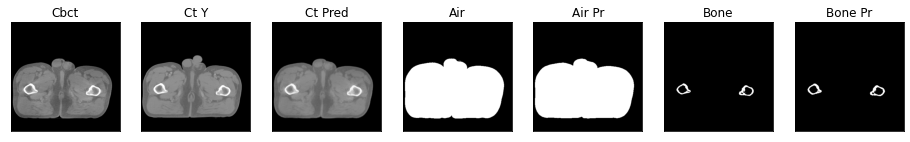

ssim score = 0.8854379653930664
psnr score = 26.442258834838867
snr score = 17.079998016357422
mae error = 0.02094586007297039
air dice score = 0.9954385714399078
bone dice score = 0.9311740890703739


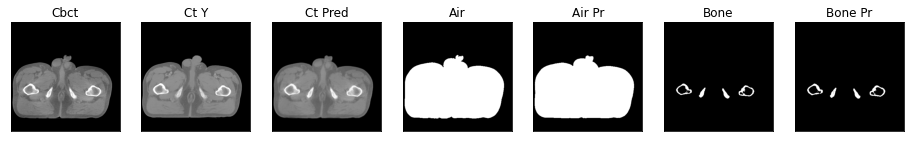

ssim score = 0.8833994269371033
psnr score = 26.184139251708984
snr score = 16.943370819091797
mae error = 0.021629156544804573
air dice score = 0.9955127952367844
bone dice score = 0.9183013580530652


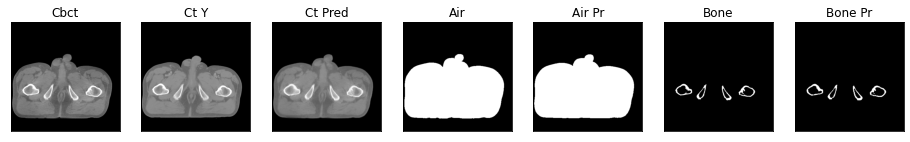

ssim score = 0.8782205581665039
psnr score = 25.927249908447266
snr score = 16.71065330505371
mae error = 0.021697167307138443
air dice score = 0.9957990465251697
bone dice score = 0.902818489291932


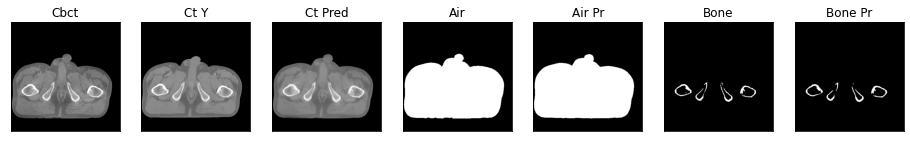

ssim score = 0.8805249333381653
psnr score = 25.9532470703125
snr score = 16.732255935668945
mae error = 0.021272752434015274
air dice score = 0.9955830805262613
bone dice score = 0.9023445463832346


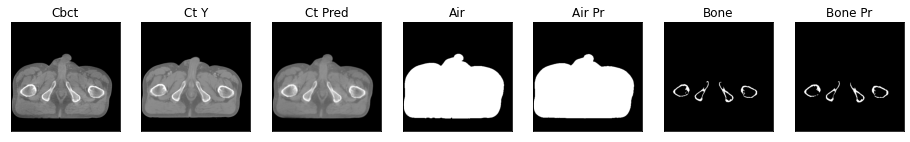

ssim score = 0.8800175189971924
psnr score = 25.463520050048828
snr score = 16.248779296875
mae error = 0.021937426179647446
air dice score = 0.995961342028761
bone dice score = 0.8957421408695634


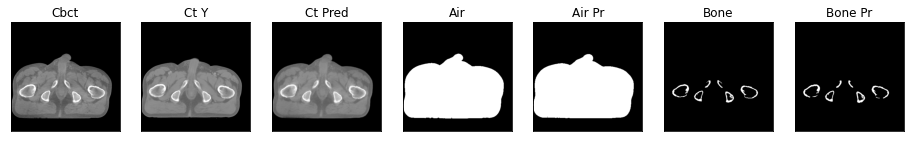

11it [00:24,  2.23s/it]

ssim score = 0.877882182598114
psnr score = 25.191011428833008
snr score = 15.95471477508545
mae error = 0.0217757485806942
air dice score = 0.9961218052092131
bone dice score = 0.9069904053278444


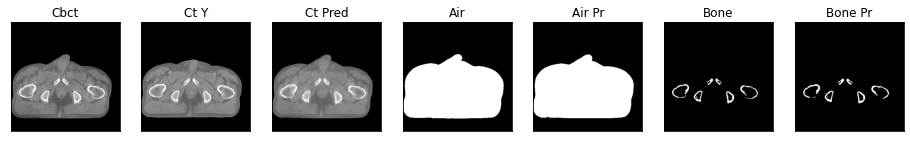

ssim score = 0.8798784017562866
psnr score = 25.29804229736328
snr score = 16.078659057617188
mae error = 0.021364951506257057
air dice score = 0.9961966985449641
bone dice score = 0.915587967184766


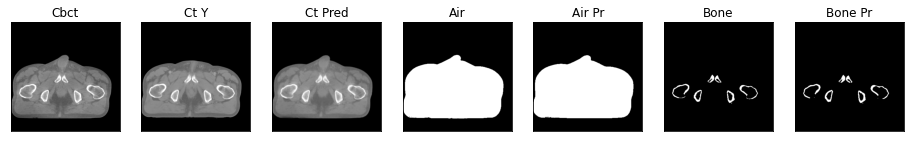

ssim score = 0.8797740340232849
psnr score = 25.54572296142578
snr score = 16.39493179321289
mae error = 0.021280910819768906
air dice score = 0.9962376535631431
bone dice score = 0.9133299543856508


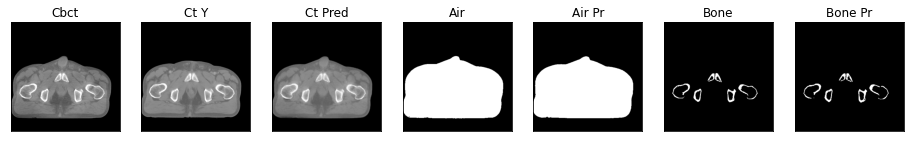

ssim score = 0.8813602924346924
psnr score = 26.005699157714844
snr score = 16.93626594543457
mae error = 0.02066837064921856
air dice score = 0.996468904087803
bone dice score = 0.9055203340048629


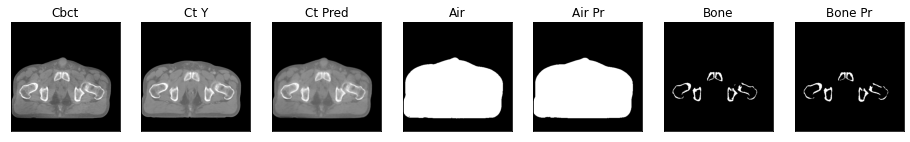

ssim score = 0.882624626159668
psnr score = 26.58700180053711
snr score = 17.56827163696289
mae error = 0.01994749903678894
air dice score = 0.9954250401207251
bone dice score = 0.8830973184711796


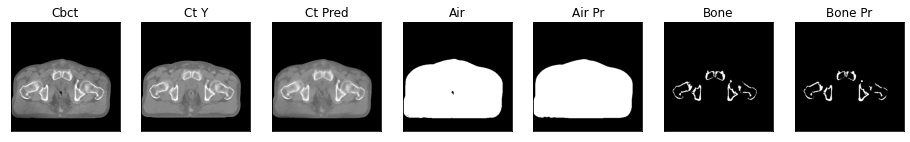

ssim score = 0.8848295211791992
psnr score = 26.957107543945312
snr score = 18.054645538330078
mae error = 0.01974850334227085
air dice score = 0.9957161273791542
bone dice score = 0.8719177117109776


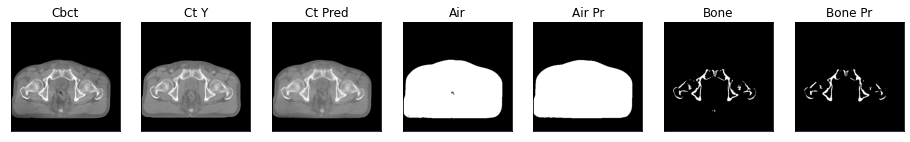

ssim score = 0.8850008845329285
psnr score = 27.220571517944336
snr score = 18.27987289428711
mae error = 0.019344385713338852
air dice score = 0.9939262298379036
bone dice score = 0.8513011152439389


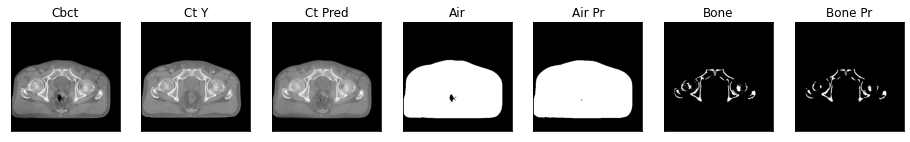

ssim score = 0.8798202276229858
psnr score = 27.110904693603516
snr score = 18.074539184570312
mae error = 0.01955551654100418
air dice score = 0.9902651570371169
bone dice score = 0.8442728442750712


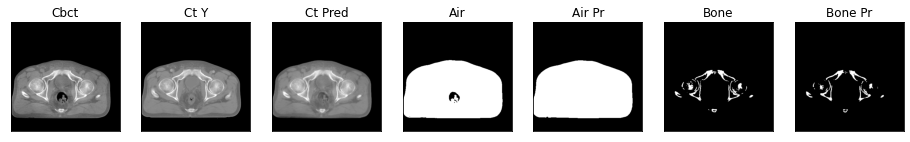

12it [00:27,  2.25s/it]

ssim score = 0.8848092555999756
psnr score = 27.198776245117188
snr score = 18.002649307250977
mae error = 0.019428914412856102
air dice score = 0.988309045021584
bone dice score = 0.8417085427164087


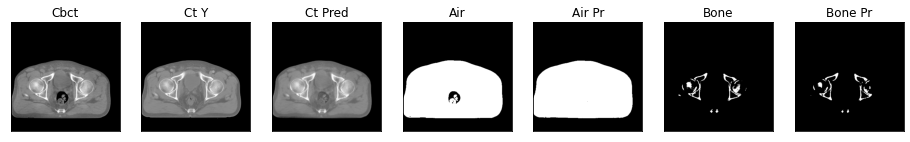

ssim score = 0.8866809606552124
psnr score = 27.340606689453125
snr score = 18.028057098388672
mae error = 0.018592456355690956
air dice score = 0.9858493663405461
bone dice score = 0.8402829486254602


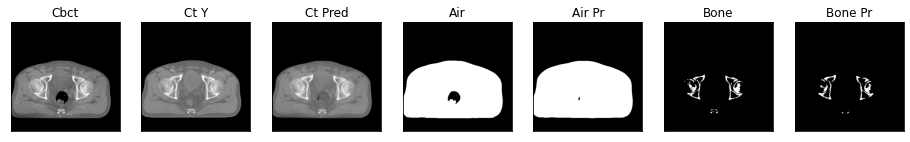

ssim score = 0.884929895401001
psnr score = 27.373306274414062
snr score = 18.015661239624023
mae error = 0.01822640933096409
air dice score = 0.9848072000660681
bone dice score = 0.871148936172406


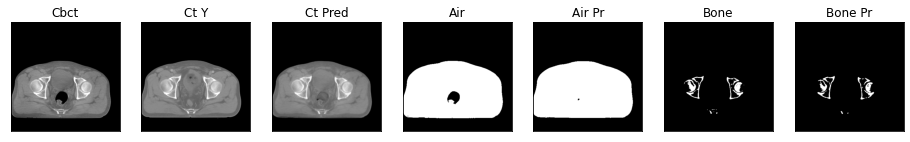

ssim score = 0.8764841556549072
psnr score = 26.17041778564453
snr score = 16.819446563720703
mae error = 0.020518912002444267
air dice score = 0.9864224137931147
bone dice score = 0.9047540713948881


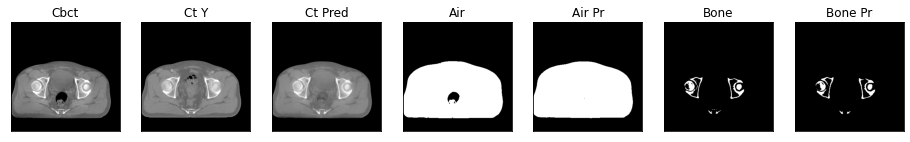

ssim score = 0.8749649524688721
psnr score = 25.315980911254883
snr score = 15.995111465454102
mae error = 0.022192049771547318
air dice score = 0.9881667637513621
bone dice score = 0.9290146813995911


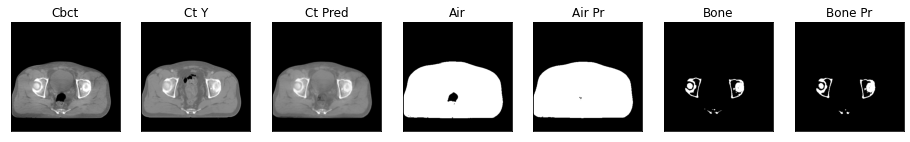

ssim score = 0.8788628578186035
psnr score = 25.02878189086914
snr score = 15.665328979492188
mae error = 0.022311167791485786
air dice score = 0.9919829146818677
bone dice score = 0.9238062986805993


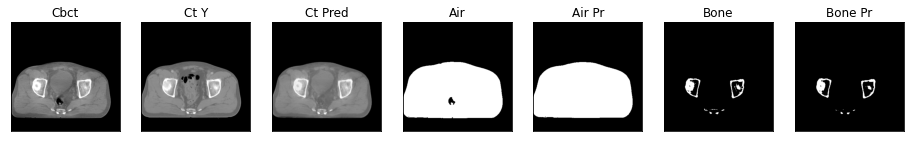

ssim score = 0.8802080750465393
psnr score = 24.918434143066406
snr score = 15.464775085449219
mae error = 0.02152695693075657
air dice score = 0.9937526729335655
bone dice score = 0.9083269671522474


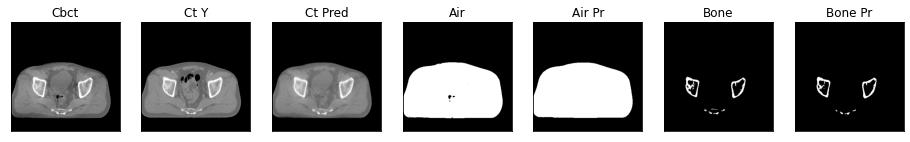

ssim score = 0.8813430070877075
psnr score = 24.95404052734375
snr score = 15.434656143188477
mae error = 0.021142007783055305
air dice score = 0.9925349790759669
bone dice score = 0.9245541838149215


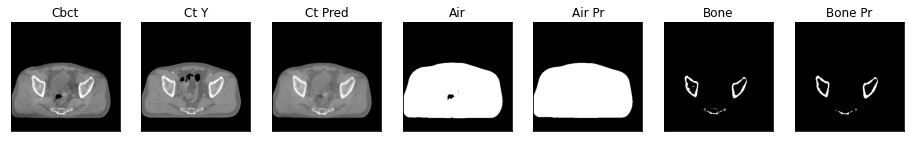

13it [00:29,  2.20s/it]

ssim score = 0.8807050585746765
psnr score = 25.15550422668457
snr score = 15.63581657409668
mae error = 0.020879054442048073
air dice score = 0.9921713769166549
bone dice score = 0.9326873161458265


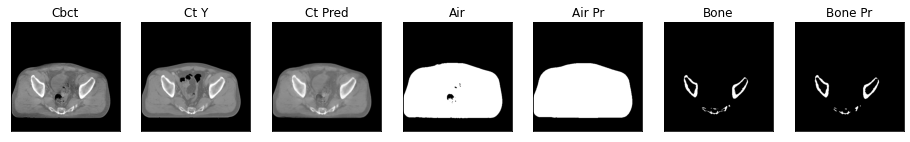

ssim score = 0.8777201771736145
psnr score = 25.25028419494629
snr score = 15.8067626953125
mae error = 0.02149912156164646
air dice score = 0.9908446341295597
bone dice score = 0.9166190748155822


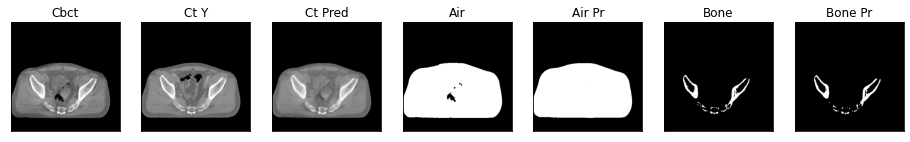

ssim score = 0.8810833096504211
psnr score = 25.42707061767578
snr score = 16.01913070678711
mae error = 0.020839711651206017
air dice score = 0.9900854404302467
bone dice score = 0.9227941176480725


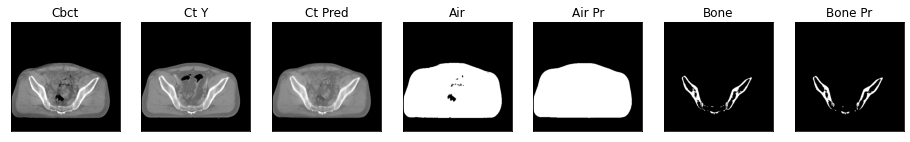

ssim score = 0.8827717900276184
psnr score = 25.716064453125
snr score = 16.246427536010742
mae error = 0.020010516047477722
air dice score = 0.9915693564434278
bone dice score = 0.9101746603838345


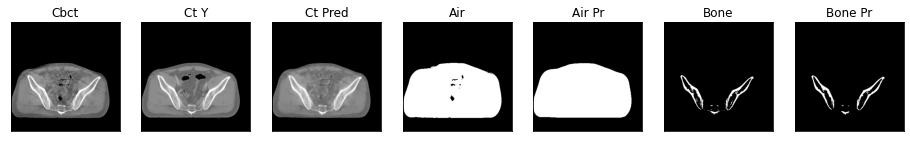

ssim score = 0.8778892755508423
psnr score = 25.35327911376953
snr score = 15.822381019592285
mae error = 0.020584771409630775
air dice score = 0.9918498612273741
bone dice score = 0.8971061093262627


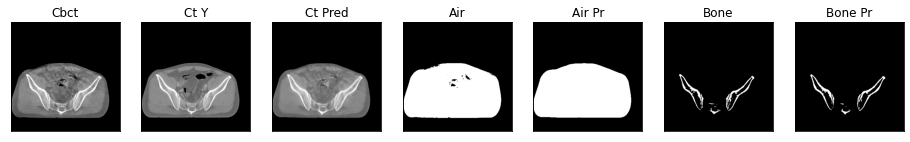

ssim score = 0.8087708950042725
psnr score = 22.86882209777832
snr score = 14.566129684448242
mae error = 0.03169187158346176
air dice score = 0.9963266087539209
bone dice score = 0.9525888958218157


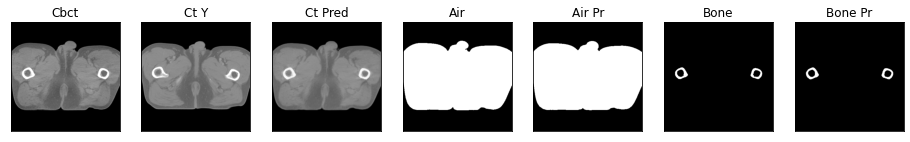

ssim score = 0.7998837828636169
psnr score = 22.525676727294922
snr score = 14.327274322509766
mae error = 0.032653894275426865
air dice score = 0.9965374455629349
bone dice score = 0.9497487437199958


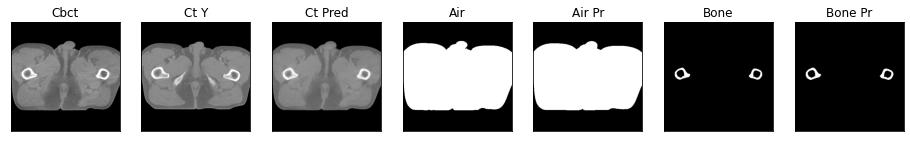

ssim score = 0.7938989400863647
psnr score = 22.160245895385742
snr score = 14.089801788330078
mae error = 0.034504786133766174
air dice score = 0.9968687359893745
bone dice score = 0.9216757741365739


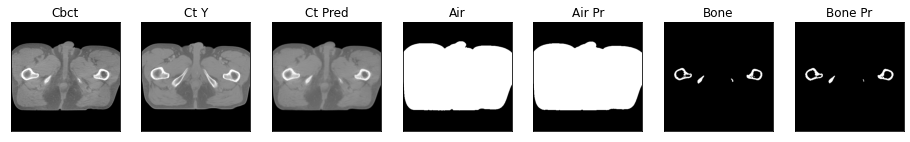

14it [00:31,  2.23s/it]

ssim score = 0.783409059047699
psnr score = 21.833372116088867
snr score = 13.795215606689453
mae error = 0.03518376126885414
air dice score = 0.9966751464237137
bone dice score = 0.9286302950399105


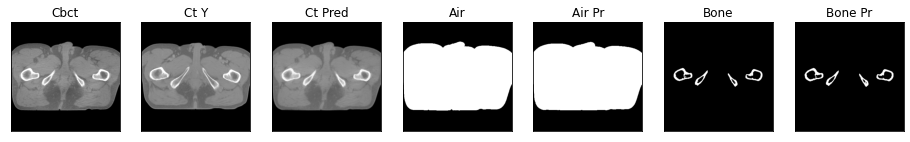

ssim score = 0.775243878364563
psnr score = 21.74292755126953
snr score = 13.73500919342041
mae error = 0.03550245240330696
air dice score = 0.996501413004362
bone dice score = 0.9123486682822866


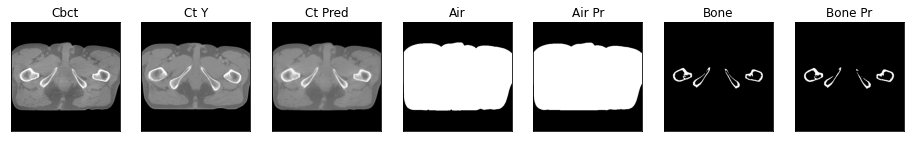

ssim score = 0.767441987991333
psnr score = 21.625520706176758
snr score = 13.652018547058105
mae error = 0.0367068350315094
air dice score = 0.9965012554318765
bone dice score = 0.9211009174323991


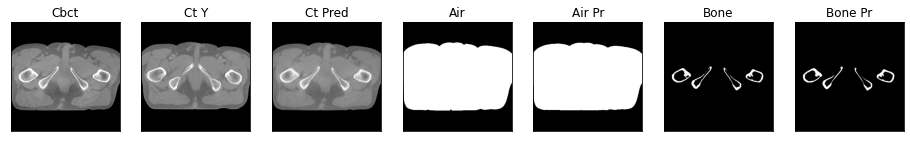

ssim score = 0.7583750486373901
psnr score = 21.297706604003906
snr score = 13.34451675415039
mae error = 0.038172412663698196
air dice score = 0.9968948830015368
bone dice score = 0.9206092465302519


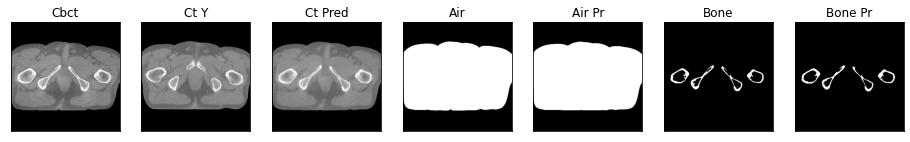

ssim score = 0.7563889026641846
psnr score = 21.327131271362305
snr score = 13.41301155090332
mae error = 0.03760693594813347
air dice score = 0.996915440939768
bone dice score = 0.9219251336908834


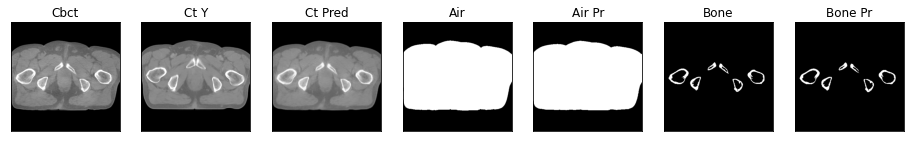

ssim score = 0.754871666431427
psnr score = 21.442068099975586
snr score = 13.576629638671875
mae error = 0.037537336349487305
air dice score = 0.9973533510557334
bone dice score = 0.9298721425813009


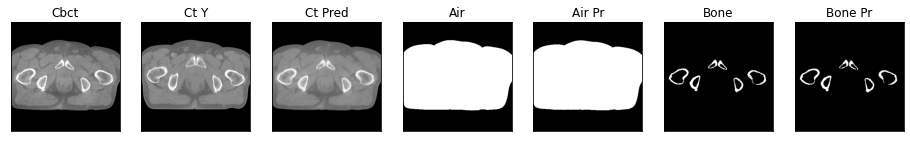

ssim score = 0.7503746747970581
psnr score = 21.278308868408203
snr score = 13.4354829788208
mae error = 0.03887728601694107
air dice score = 0.9972671679784666
bone dice score = 0.930359355639029


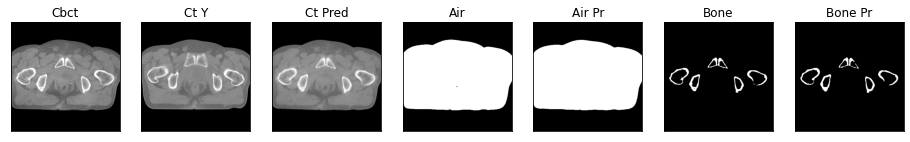

ssim score = 0.7414119839668274
psnr score = 21.264354705810547
snr score = 13.464306831359863
mae error = 0.039918456226587296
air dice score = 0.9970892418612536
bone dice score = 0.912621359224323


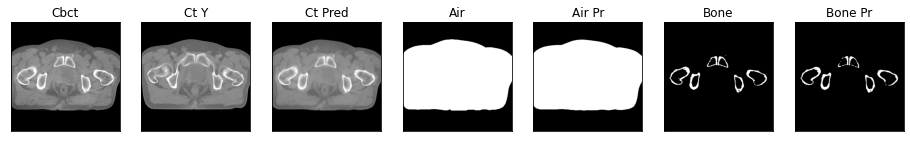

15it [00:33,  2.20s/it]

ssim score = 0.7429301738739014
psnr score = 21.365678787231445
snr score = 13.623967170715332
mae error = 0.03984801843762398
air dice score = 0.9968404699146421
bone dice score = 0.9148020654053916


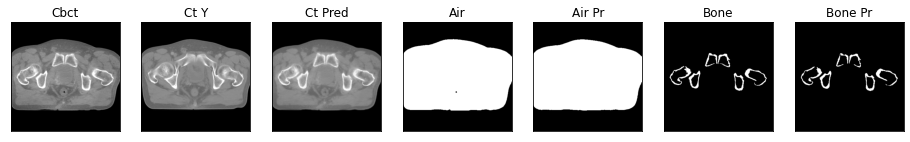

ssim score = 0.7360566854476929
psnr score = 21.162948608398438
snr score = 13.345865249633789
mae error = 0.04143529012799263
air dice score = 0.9968630549197773
bone dice score = 0.9053546729904628


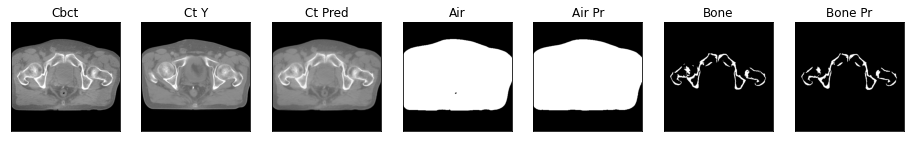

ssim score = 0.738858699798584
psnr score = 21.046443939208984
snr score = 13.122143745422363
mae error = 0.04220040142536163
air dice score = 0.9968685184432081
bone dice score = 0.8841649443963767


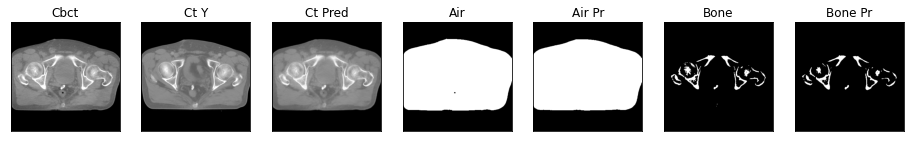

ssim score = 0.7504119873046875
psnr score = 21.237546920776367
snr score = 13.190159797668457
mae error = 0.041223663836717606
air dice score = 0.9970171817309667
bone dice score = 0.8399637425738748


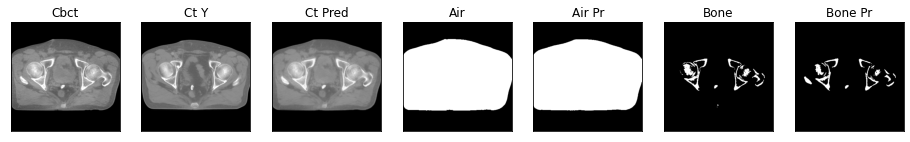

ssim score = 0.7556675672531128
psnr score = 21.50895881652832
snr score = 13.349138259887695
mae error = 0.03963726758956909
air dice score = 0.9969579001352062
bone dice score = 0.8640879306714849


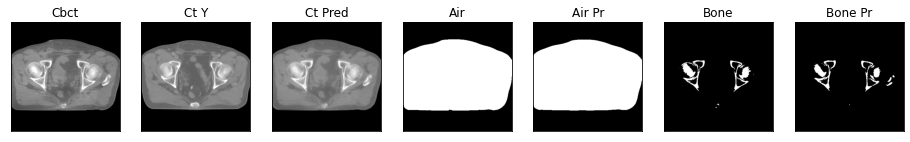

ssim score = 0.7524412274360657
psnr score = 21.823522567749023
snr score = 13.613056182861328
mae error = 0.03712727129459381
air dice score = 0.9970022964863192
bone dice score = 0.8954588960981021


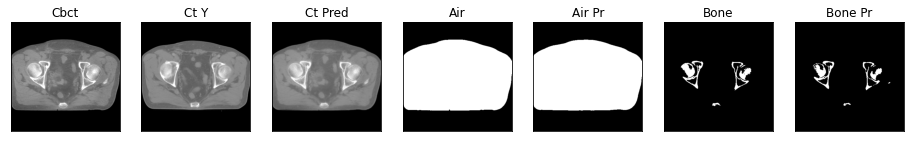

ssim score = 0.7515721321105957
psnr score = 21.618844985961914
snr score = 13.440534591674805
mae error = 0.03822110965847969
air dice score = 0.9971216020541578
bone dice score = 0.8972045884853858


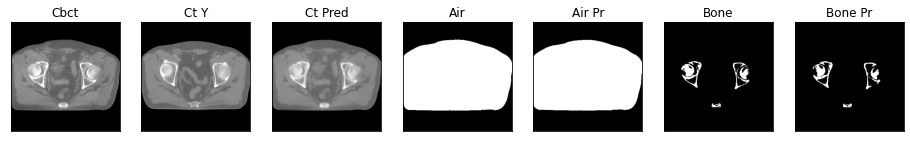

ssim score = 0.7502431273460388
psnr score = 21.381622314453125
snr score = 13.216789245605469
mae error = 0.03949722647666931
air dice score = 0.9970973192889921
bone dice score = 0.8998063891590051


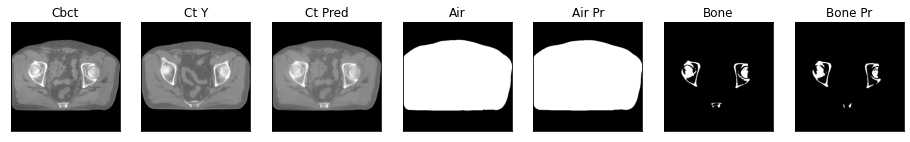

16it [00:35,  2.23s/it]

ssim score = 0.746725857257843
psnr score = 21.0709285736084
snr score = 12.764601707458496
mae error = 0.04095696285367012
air dice score = 0.9968452018064642
bone dice score = 0.9206498704977554


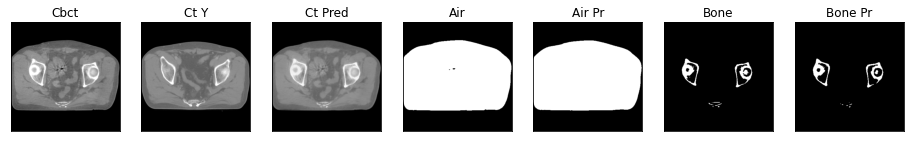

ssim score = 0.7567015886306763
psnr score = 21.124969482421875
snr score = 12.759333610534668
mae error = 0.04032297432422638
air dice score = 0.9971382164127173
bone dice score = 0.9253690541289589


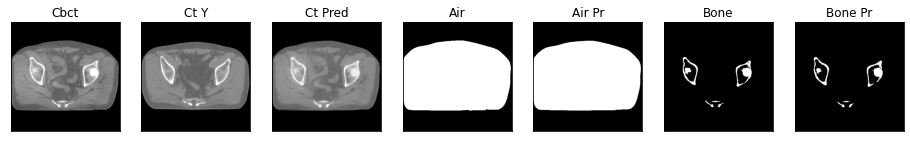

ssim score = 0.7552737593650818
psnr score = 21.433334350585938
snr score = 13.09334659576416
mae error = 0.038389261811971664
air dice score = 0.9972916579477599
bone dice score = 0.8988422850654992


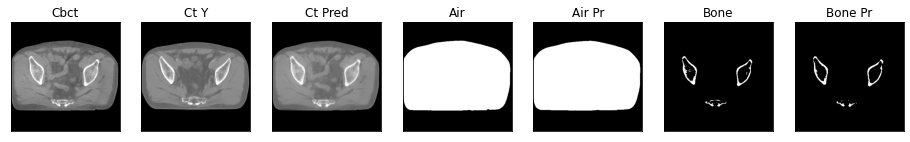

ssim score = 0.7504460215568542
psnr score = 21.38931655883789
snr score = 13.12214469909668
mae error = 0.03854973614215851
air dice score = 0.9968257403599918
bone dice score = 0.9138840070313904


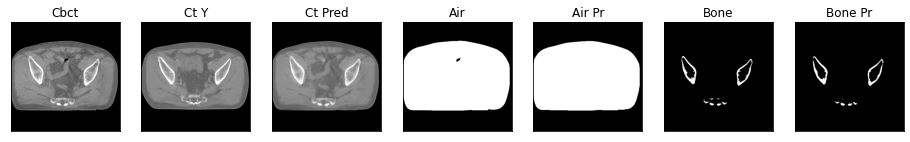

ssim score = 0.7441691160202026
psnr score = 21.108749389648438
snr score = 12.970805168151855
mae error = 0.04011888802051544
air dice score = 0.9958273868556664
bone dice score = 0.9202851587828859


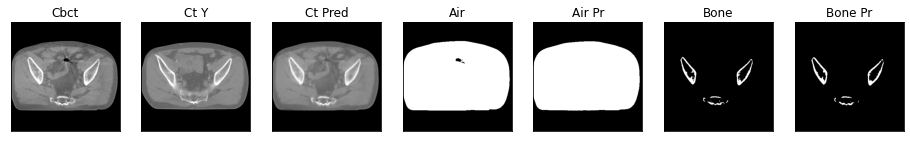

ssim score = 0.7364031672477722
psnr score = 20.983131408691406
snr score = 12.87914752960205
mae error = 0.040814511477947235
air dice score = 0.9953563006005232
bone dice score = 0.9150579150591764


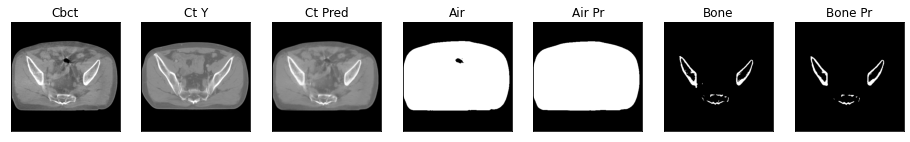

ssim score = 0.7244434356689453
psnr score = 20.82108497619629
snr score = 12.687312126159668
mae error = 0.041991159319877625
air dice score = 0.9965525026390156
bone dice score = 0.9065920700570834


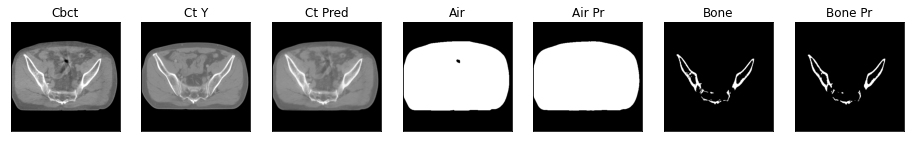

ssim score = 0.7239722609519958
psnr score = 21.02592658996582
snr score = 12.828779220581055
mae error = 0.04061748459935188
air dice score = 0.9972147915990786
bone dice score = 0.8996272972638526


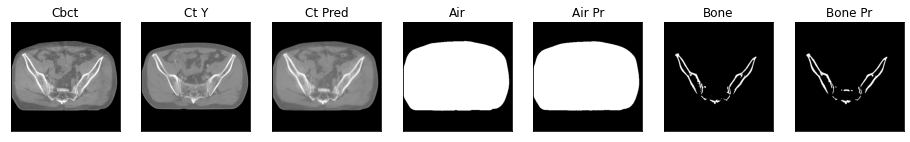

17it [00:38,  2.19s/it]

ssim score = 0.8453119397163391
psnr score = 23.595731735229492
snr score = 15.073122024536133
mae error = 0.029606664553284645
air dice score = 0.9945351896100805
bone dice score = 0.8994502138069707


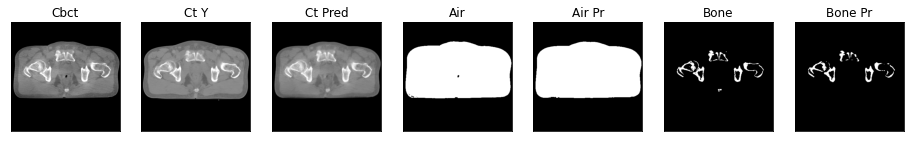

ssim score = 0.8510714173316956
psnr score = 23.861717224121094
snr score = 15.379119873046875
mae error = 0.0282375980168581
air dice score = 0.993894201378149
bone dice score = 0.8995300393763556


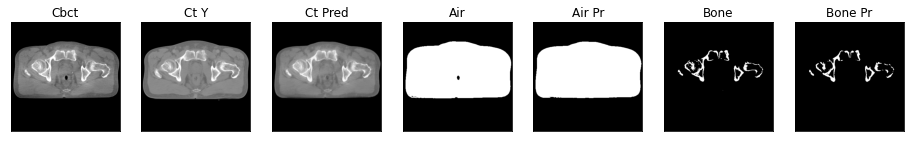

ssim score = 0.8483155369758606
psnr score = 23.889328002929688
snr score = 15.414518356323242
mae error = 0.028656184673309326
air dice score = 0.9942288226496093
bone dice score = 0.8676351896708685


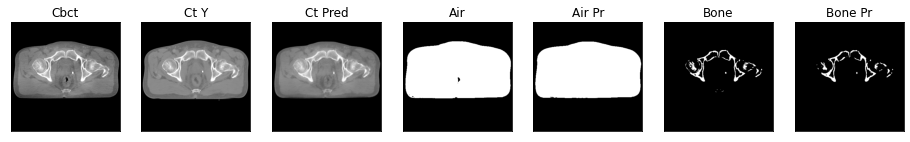

ssim score = 0.8542792797088623
psnr score = 24.101179122924805
snr score = 15.567950248718262
mae error = 0.02719430811703205
air dice score = 0.9937811981608755
bone dice score = 0.8720900486074177


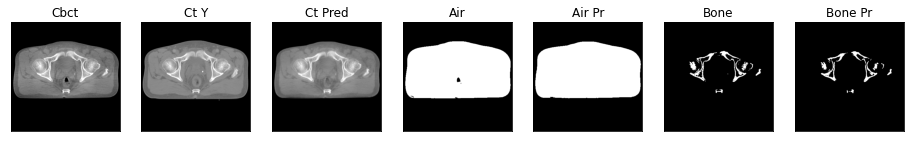

ssim score = 0.859695315361023
psnr score = 24.260494232177734
snr score = 15.571640968322754
mae error = 0.025778107345104218
air dice score = 0.9938583239069912
bone dice score = 0.8625930521113121


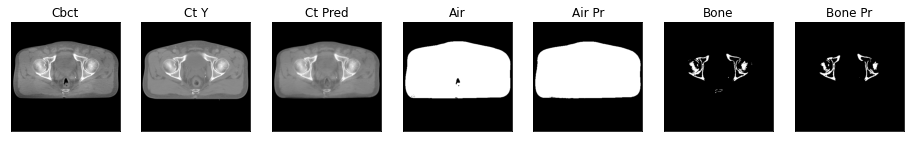

ssim score = 0.8639755845069885
psnr score = 24.389820098876953
snr score = 15.68016242980957
mae error = 0.02535141445696354
air dice score = 0.9946858726436683
bone dice score = 0.8886981402018784


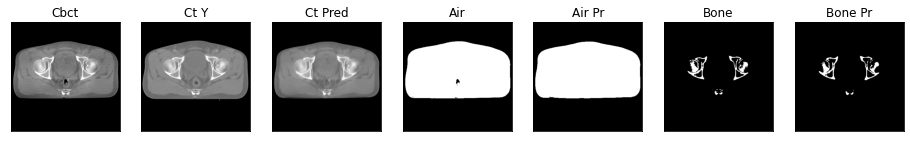

ssim score = 0.8599108457565308
psnr score = 24.458539962768555
snr score = 15.73325252532959
mae error = 0.02530350349843502
air dice score = 0.9946702910723598
bone dice score = 0.8970998326840895


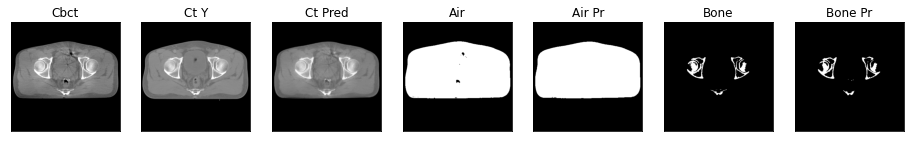

ssim score = 0.8541496992111206
psnr score = 24.02503204345703
snr score = 15.309110641479492
mae error = 0.02602532133460045
air dice score = 0.9940216141641802
bone dice score = 0.8997054285327577


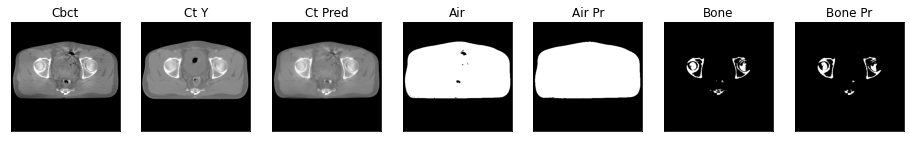

18it [00:40,  2.22s/it]

ssim score = 0.8486278653144836
psnr score = 23.94405746459961
snr score = 15.283914566040039
mae error = 0.02713172696530819
air dice score = 0.9931755056819546
bone dice score = 0.9224764468381901


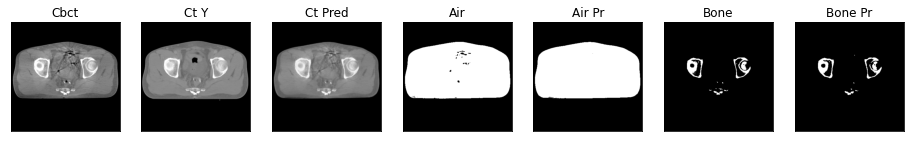

ssim score = 0.8471125960350037
psnr score = 23.475624084472656
snr score = 14.793550491333008
mae error = 0.02832525037229061
air dice score = 0.9913441325584338
bone dice score = 0.9177029481637878


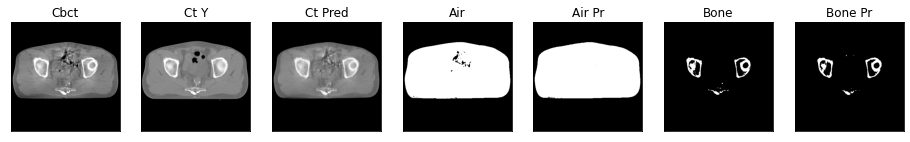

ssim score = 0.8496941924095154
psnr score = 23.021488189697266
snr score = 14.26864242553711
mae error = 0.028278019279241562
air dice score = 0.9906297229219216
bone dice score = 0.8916978776546239


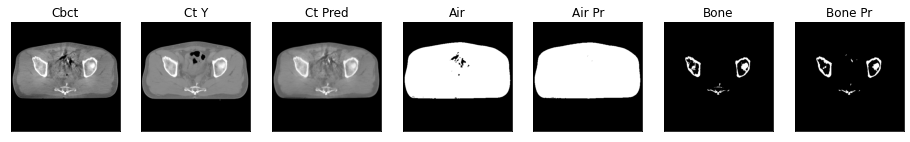

ssim score = 0.8505940437316895
psnr score = 23.281253814697266
snr score = 14.484515190124512
mae error = 0.027512677013874054
air dice score = 0.9929200108565058
bone dice score = 0.9057971014508268


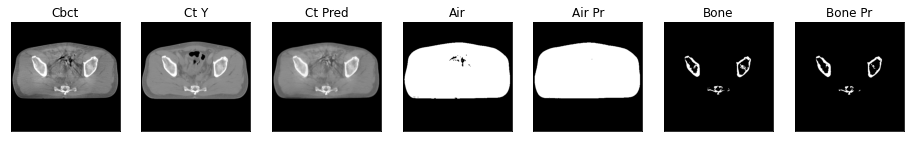

ssim score = 0.8542445302009583
psnr score = 23.7696475982666
snr score = 14.971811294555664
mae error = 0.026442594826221466
air dice score = 0.9927227491836474
bone dice score = 0.9129668216074216


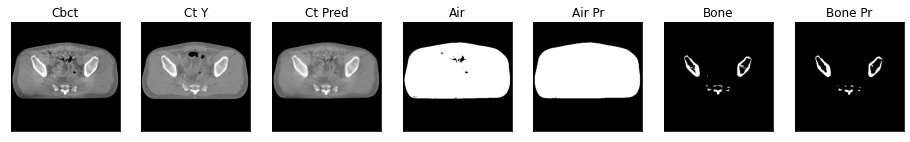

ssim score = 0.8496902585029602
psnr score = 24.061302185058594
snr score = 15.276824951171875
mae error = 0.026364827528595924
air dice score = 0.9904093420980714
bone dice score = 0.918579736762801


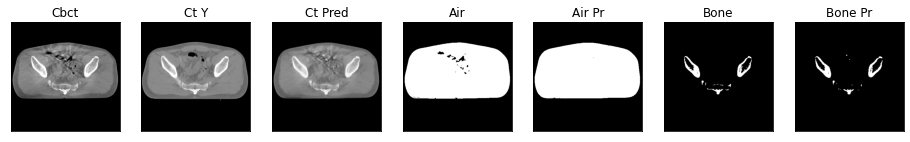

ssim score = 0.848703145980835
psnr score = 24.28532600402832
snr score = 15.556050300598145
mae error = 0.02633676677942276
air dice score = 0.9892887947933904
bone dice score = 0.9332826940127449


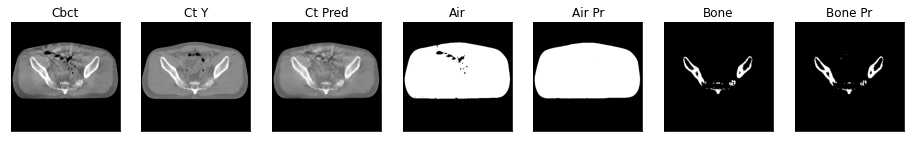

ssim score = 0.8494169116020203
psnr score = 23.66901206970215
snr score = 14.959107398986816
mae error = 0.02688605524599552
air dice score = 0.9894477139332688
bone dice score = 0.9235098490672358


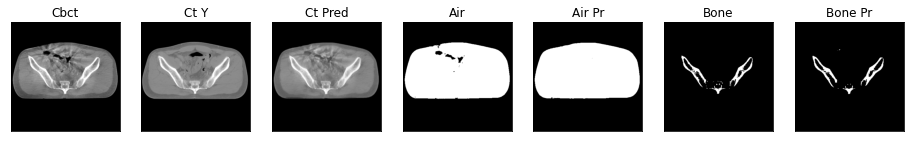

19it [00:42,  2.24s/it]

ssim score = 0.8543739914894104
psnr score = 23.39016342163086
snr score = 14.625520706176758
mae error = 0.02656117081642151
air dice score = 0.9913013386186028
bone dice score = 0.9083462787754788


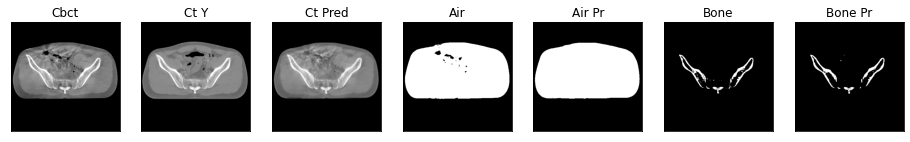

ssim score = 0.8553608059883118
psnr score = 23.425052642822266
snr score = 14.62405776977539
mae error = 0.02644393779337406
air dice score = 0.9929915914829407
bone dice score = 0.8985671726500416


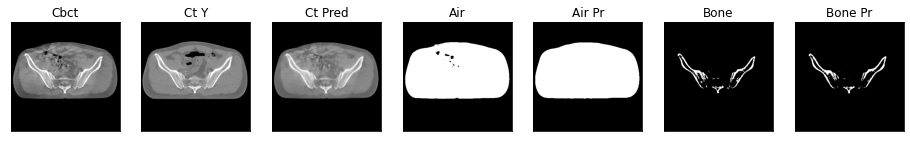

ssim score = 0.8586410880088806
psnr score = 23.539260864257812
snr score = 14.7383394241333
mae error = 0.025754807516932487
air dice score = 0.993487186747846
bone dice score = 0.8916408668744629


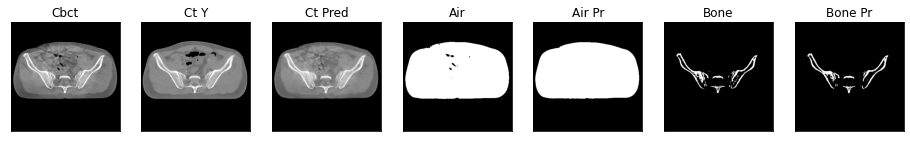

ssim score = 0.8593087196350098
psnr score = 24.01627540588379
snr score = 15.21392822265625
mae error = 0.025148604065179825
air dice score = 0.9924281223161654
bone dice score = 0.898891063275944


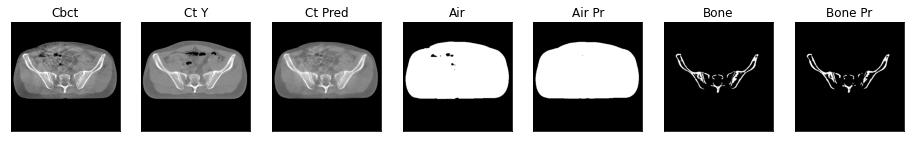

ssim score = 0.8466306924819946
psnr score = 23.589181900024414
snr score = 14.791873931884766
mae error = 0.026326706632971764
air dice score = 0.9898484788543025
bone dice score = 0.8908827022048966


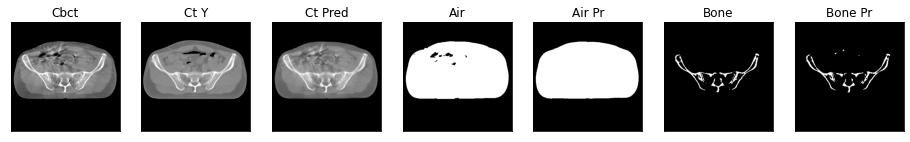

ssim score = 0.8429890275001526
psnr score = 23.324548721313477
snr score = 14.509969711303711
mae error = 0.026858115568757057
air dice score = 0.9874164341529047
bone dice score = 0.8752786885262258


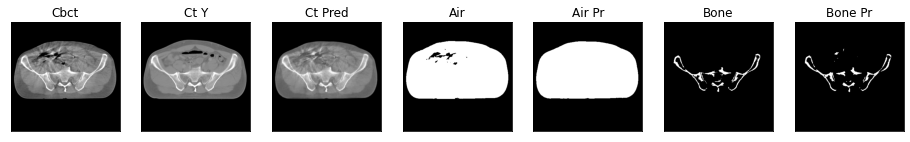

ssim score = 0.8357813358306885
psnr score = 22.794418334960938
snr score = 13.961215019226074
mae error = 0.02834845334291458
air dice score = 0.9870761091280063
bone dice score = 0.866558885712392


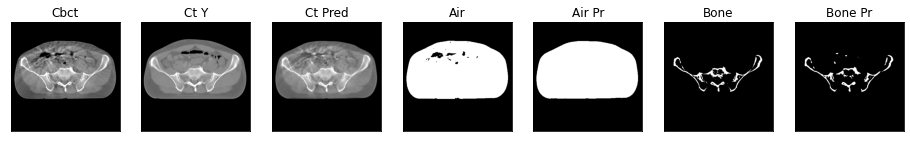

ssim score = 0.8279480338096619
psnr score = 22.392728805541992
snr score = 13.513586044311523
mae error = 0.029541410505771637
air dice score = 0.9866455681028182
bone dice score = 0.8671008200691376


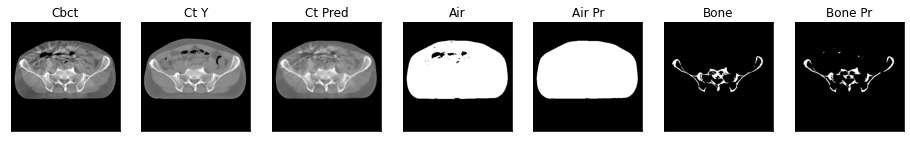

20it [00:44,  2.20s/it]

ssim score = 0.8209764957427979
psnr score = 22.487808227539062
snr score = 13.554868698120117
mae error = 0.02978789433836937
air dice score = 0.9857823707816601
bone dice score = 0.8844621513957761


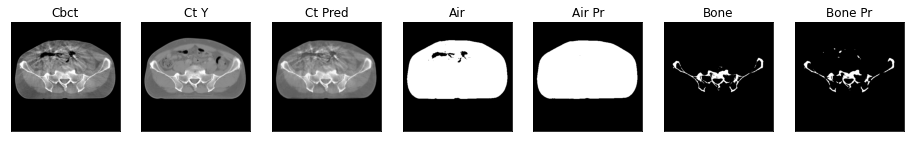

ssim score = 0.8141926527023315
psnr score = 22.23117446899414
snr score = 13.328697204589844
mae error = 0.031129976734519005
air dice score = 0.9855200779130999
bone dice score = 0.9028048082438144


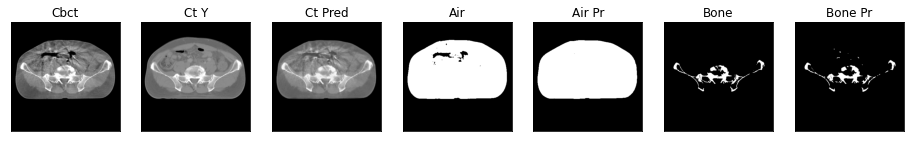

ssim score = 0.8076399564743042
psnr score = 21.80779457092285
snr score = 12.850092887878418
mae error = 0.03162773326039314
air dice score = 0.9868895576335153
bone dice score = 0.902548001450277


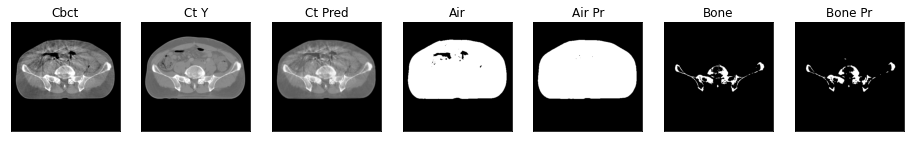

ssim score = 0.8146896958351135
psnr score = 22.505691528320312
snr score = 13.400457382202148
mae error = 0.029497070237994194
air dice score = 0.9898450113012675
bone dice score = 0.9114368032079239


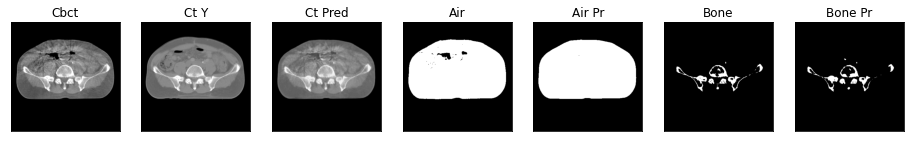

ssim score = 0.8795233964920044
psnr score = 26.539113998413086
snr score = 16.920024871826172
mae error = 0.018472040072083473
air dice score = 0.9962521550108716
bone dice score = 0.933225632742778


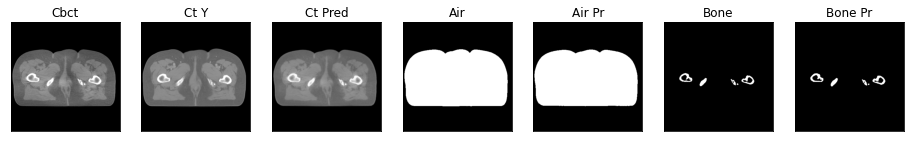

ssim score = 0.8799827098846436
psnr score = 26.62950325012207
snr score = 17.131427764892578
mae error = 0.01869216002523899
air dice score = 0.99603718491151
bone dice score = 0.9289914066049527


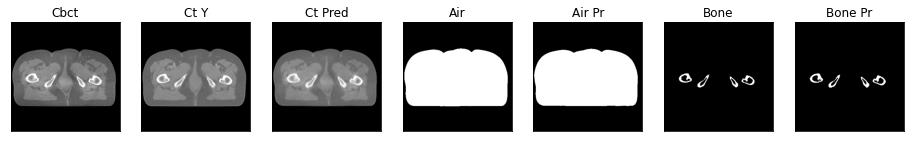

ssim score = 0.8765138983726501
psnr score = 26.566457748413086
snr score = 17.151296615600586
mae error = 0.019110240042209625
air dice score = 0.9960908000533102
bone dice score = 0.9268595041337425


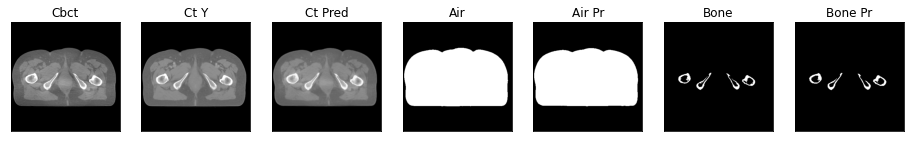

ssim score = 0.8735675811767578
psnr score = 26.50979232788086
snr score = 17.158079147338867
mae error = 0.019256118685007095
air dice score = 0.996073288786406
bone dice score = 0.9250778530880184


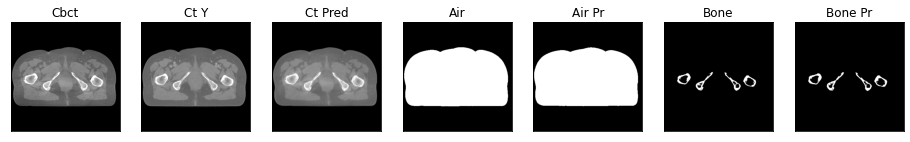

21it [00:47,  2.23s/it]

ssim score = 0.872666597366333
psnr score = 26.346397399902344
snr score = 17.023143768310547
mae error = 0.019462009891867638
air dice score = 0.9962626017871987
bone dice score = 0.9324277255323506


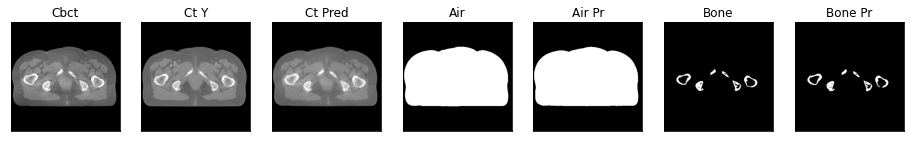

ssim score = 0.8743363618850708
psnr score = 26.274755477905273
snr score = 16.974456787109375
mae error = 0.01927734538912773
air dice score = 0.9962127039242862
bone dice score = 0.9288702928883232


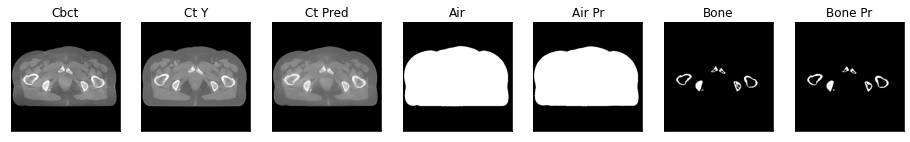

ssim score = 0.87247234582901
psnr score = 26.190433502197266
snr score = 16.92146110534668
mae error = 0.01950165070593357
air dice score = 0.9961629819112032
bone dice score = 0.9219756621345387


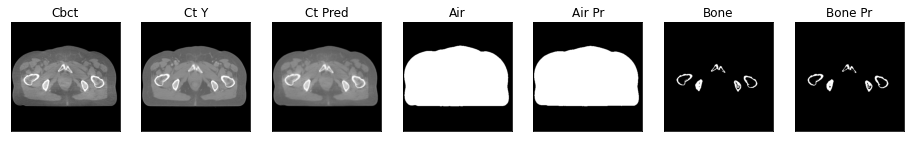

ssim score = 0.8712195754051208
psnr score = 26.072250366210938
snr score = 16.851642608642578
mae error = 0.019999640062451363
air dice score = 0.9958981096270375
bone dice score = 0.9117079164488028


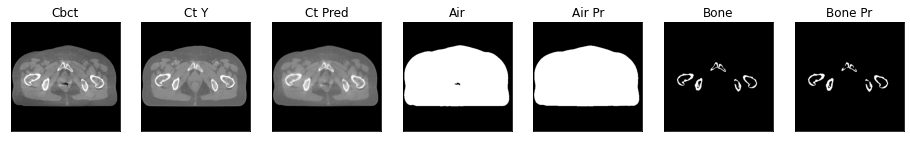

ssim score = 0.8703288435935974
psnr score = 26.038005828857422
snr score = 16.860143661499023
mae error = 0.01978430524468422
air dice score = 0.9951761331708384
bone dice score = 0.9121588089344556


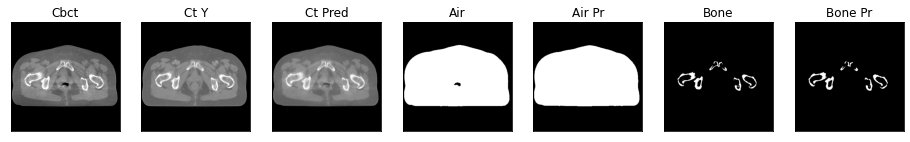

ssim score = 0.86860591173172
psnr score = 26.156352996826172
snr score = 17.066194534301758
mae error = 0.01991402544081211
air dice score = 0.9946974172702313
bone dice score = 0.9095067905659827


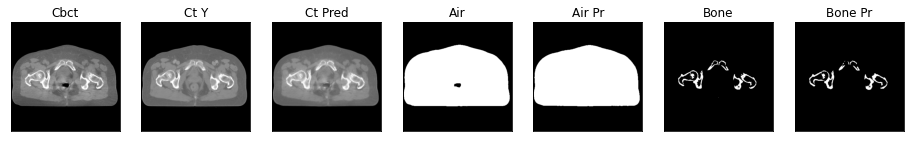

ssim score = 0.8710806369781494
psnr score = 26.631372451782227
snr score = 17.65448570251465
mae error = 0.019412124529480934
air dice score = 0.9966205167338954
bone dice score = 0.9120629996430967


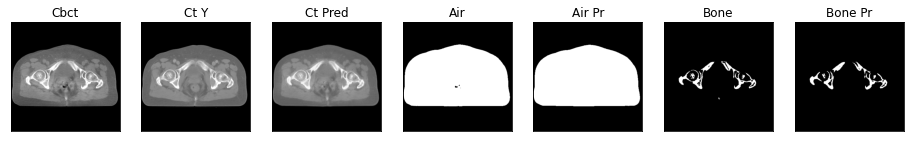

ssim score = 0.8752267956733704
psnr score = 26.955259323120117
snr score = 17.84981918334961
mae error = 0.018216827884316444
air dice score = 0.9938512973326594
bone dice score = 0.8824246646946102


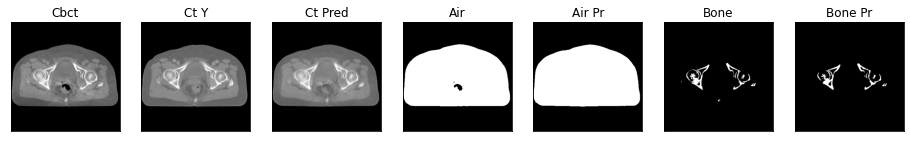

22it [00:49,  2.19s/it]

ssim score = 0.8774762153625488
psnr score = 27.317476272583008
snr score = 18.102615356445312
mae error = 0.017718061804771423
air dice score = 0.9935431448512069
bone dice score = 0.8723070897008949


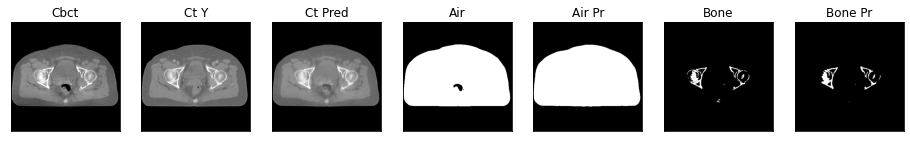

ssim score = 0.8789365291595459
psnr score = 27.203872680664062
snr score = 17.961881637573242
mae error = 0.018301617354154587
air dice score = 0.9934921254718256
bone dice score = 0.8915956151054185


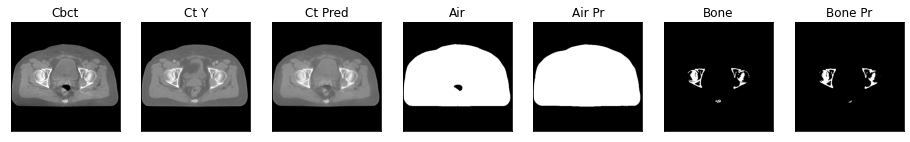

ssim score = 0.8818455338478088
psnr score = 27.08582305908203
snr score = 17.835832595825195
mae error = 0.018902281299233437
air dice score = 0.995275771456473
bone dice score = 0.9076587900132788


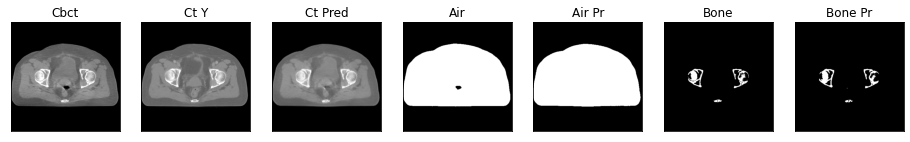

ssim score = 0.8799447417259216
psnr score = 27.29338836669922
snr score = 18.077625274658203
mae error = 0.018138963729143143
air dice score = 0.9965156794425112
bone dice score = 0.9279647687963516


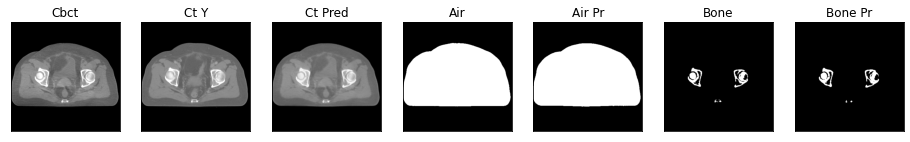

ssim score = 0.8749392032623291
psnr score = 26.61456871032715
snr score = 17.450294494628906
mae error = 0.019349873065948486
air dice score = 0.9964633318243574
bone dice score = 0.9396605908243296


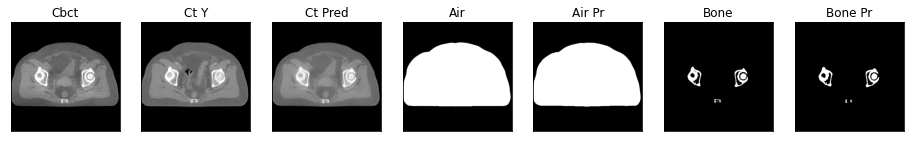

ssim score = 0.8629989624023438
psnr score = 25.532062530517578
snr score = 16.40534782409668
mae error = 0.0211776215583086
air dice score = 0.9966550962448746
bone dice score = 0.9381230663468868


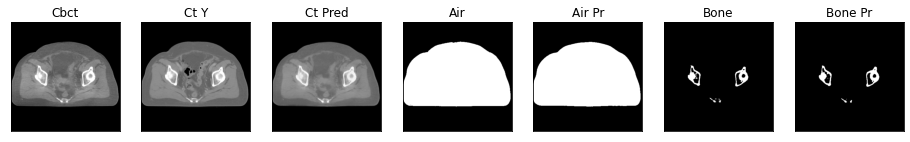

ssim score = 0.8454123735427856
psnr score = 24.056358337402344
snr score = 14.857208251953125
mae error = 0.02384337969124317
air dice score = 0.9945463283486488
bone dice score = 0.9225352112693104


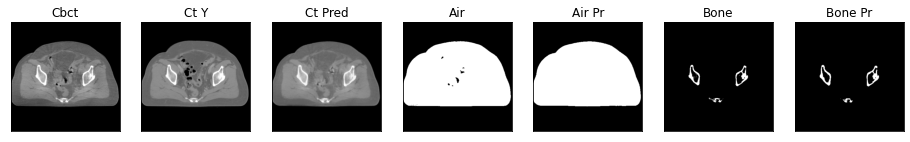

ssim score = 0.8349443078041077
psnr score = 23.948183059692383
snr score = 14.731040000915527
mae error = 0.02467302605509758
air dice score = 0.9921998174425413
bone dice score = 0.9377501111618998


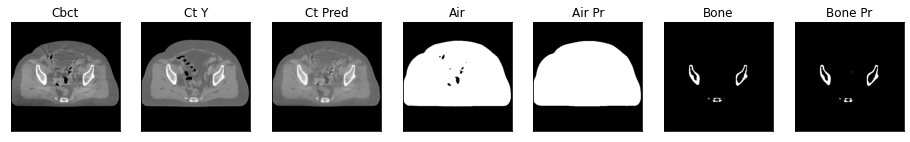

23it [00:51,  2.22s/it]

ssim score = 0.8314544558525085
psnr score = 24.368789672851562
snr score = 15.216559410095215
mae error = 0.024532770738005638
air dice score = 0.992940435351237
bone dice score = 0.9335634167400008


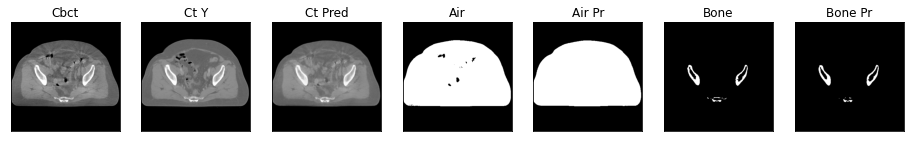

ssim score = 0.8340862393379211
psnr score = 24.365055084228516
snr score = 15.26792049407959
mae error = 0.024454033002257347
air dice score = 0.992953443851579
bone dice score = 0.9334552102388765


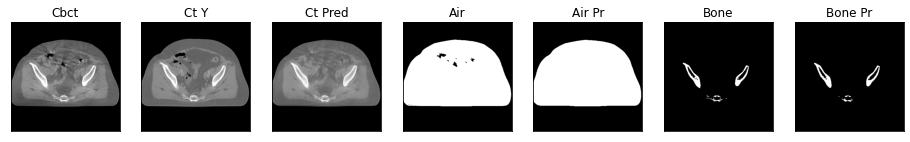

ssim score = 0.8286265730857849
psnr score = 23.93833351135254
snr score = 14.90562915802002
mae error = 0.025592954829335213
air dice score = 0.9937384403268698
bone dice score = 0.9371775417308471


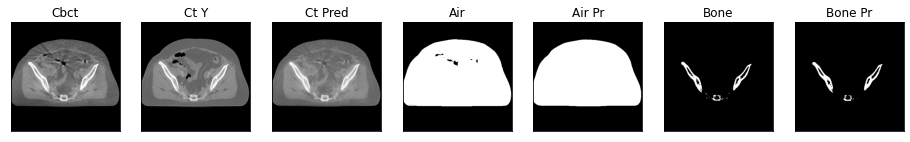

ssim score = 0.82713383436203
psnr score = 23.95992660522461
snr score = 15.000081062316895
mae error = 0.026013918220996857
air dice score = 0.9929777997105806
bone dice score = 0.9182569068653054


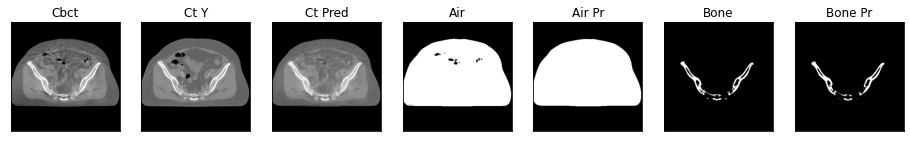

ssim score = 0.8281407356262207
psnr score = 24.058914184570312
snr score = 15.094778060913086
mae error = 0.025769244879484177
air dice score = 0.9927125077702438
bone dice score = 0.8989738401517708


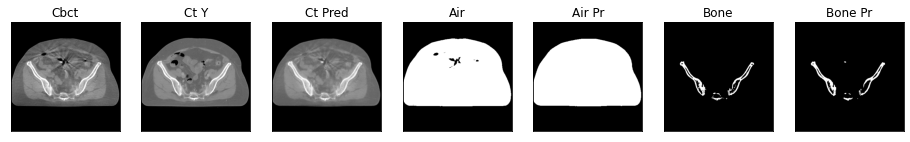

ssim score = 0.8271932005882263
psnr score = 23.838014602661133
snr score = 14.851702690124512
mae error = 0.026013130322098732
air dice score = 0.9940067988445933
bone dice score = 0.9036330481146916


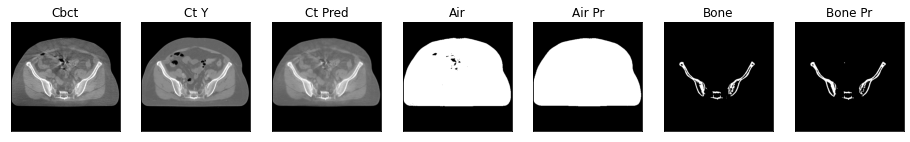

ssim score = 0.8347288966178894
psnr score = 24.381088256835938
snr score = 15.406412124633789
mae error = 0.02498042583465576
air dice score = 0.9955338595762389
bone dice score = 0.9088750371043504


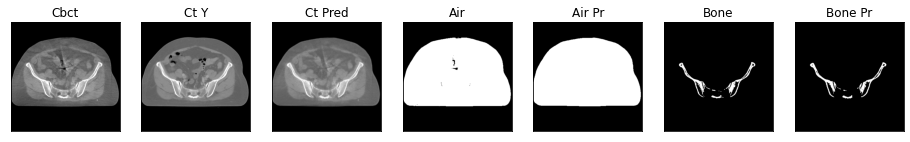

24it [00:53,  2.22s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [36]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [37]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [38]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:06,  3.43it/s]


(0.845736729602019,
 24.249690612157185,
 15.26426096757253,
 0.02614070374208192,
 0.9928289310865658,
 0.9158850598350609,
 0.3333333333333333)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)